# Run Analysis on Results of A Regression

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

We do some fancy stuff in here. Many miscellaneous methods ensue. 

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [ ]:
# Specify the path to your CSV file containing data for regression
input_csv_path = '/Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/metadata/master_list_proper_subjects.xlsx'

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/prospective_planning/redone_joint_dist'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet='master_list_proper_subjects')
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()

# 01 - Preprocess Your Data

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [ ]:
column = 'City'  # The column you'd like to evaluate
condition = 'not'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'Toronto'  # The value to compare against

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['Age', 'Z_Scored_Percent_Cognitive_Improvement']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Z_Scored_Percent_Cognitive_Improvement', 'Z_Scored_Subiculum_Connectivity']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

Descriptive Stats

In [ ]:
data_df.describe()

## Generate Statsmodel Linear Model

In [35]:
data_df.columns

Index(['subject', 'Age', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T_Redone',
       'Subiculum_Connectivity_T', 'Amnesia_Lesion_T_Map', 'Memory_Network_T',
       'Z_Scored_Memory_Network_R', 'Memory_Network_R',
       'Subiculum_Grey_Matter', 'Subiculum_White_Matter', 'Subiculum_CSF',
       'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivity',
       'Standardized_Subiculum_Grey_Matter',
       'Standardized_Subiculum_White_Matter', 'Standardized_Subiculum_CSF',
       'Standardized_Subiculum_Total', 'Disease', 'Cohort', 'City',
       'Inclusion_Cohort', 'Categorical_Age_Group', 'Age_Group',
       'Age_And_Disease', 'Age_Disease_and_Cohort',

In [36]:
import statsmodels.formula.api as smf

formula = "Percent_Cognitive_Improvement ~ Age*Subiculum_Connectivity_T_Redone"
#----------------------------------------------------------------DO NOT TOUCH
results = smf.ols(formula, data=data_df).fit()
print(results.summary2())

                            Results: Ordinary least squares
Model:                  OLS                              Adj. R-squared:        0.075   
Dependent Variable:     Percent_Cognitive_Improvement    AIC:                   490.2496
Date:                   2024-04-18 14:36                 BIC:                   497.5641
No. Observations:       46                               Log-Likelihood:        -241.12 
Df Model:               3                                F-statistic:           2.219   
Df Residuals:           42                               Prob (F-statistic):    0.100   
R-squared:              0.137                            Scale:                 2291.1  
----------------------------------------------------------------------------------------
                                      Coef.   Std.Err.    t    P>|t|   [0.025    0.975] 
----------------------------------------------------------------------------------------
Intercept                           1021.9003 545.

Run Diagnostics on the Model

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import model_diagnostics
model_diagnostics(results)

Cross Validation - LOOCV

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn.model_selection import LeaveOneOut
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

def leave_one_out_cv(data_df: pd.DataFrame, formula: str) -> tuple:
    """
    Performs Leave-One-Out Cross Validation (LOOCV) on the provided data using the specified formula.
    
    Parameters:
    - data_df: A pandas DataFrame containing the data.
    - formula: A string in the format 'response ~ predictors' specifying the regression formula.
    
    Returns:
    - A tuple containing:
        * Average Root Mean Squared Error from LOOCV
        * Pearson Correlation Coefficient between actual and predicted values
    """
    
    # Ensure formula is correctly formatted
    formula_parts = formula.split("~")
    if len(formula_parts) != 2:
        raise ValueError("Formula should be in the format 'response ~ predictors'.")
    
    loo = LeaveOneOut()
    loo.get_n_splits(data_df)

    models = []
    squared_error_list = []
    predictions = []
    actual_values = []

    for train_index, test_index in loo.split(data_df):
        train_data, test_data = data_df.iloc[train_index], data_df.iloc[test_index]

        model = smf.ols(f'{formula_parts[0]} ~ {formula_parts[1]}', data=train_data).fit()
        models.append(model)

        test_x = test_data.drop(columns=[formula_parts[0]])
        test_y = test_data[formula_parts[0]]
        pred_y = model.predict(test_x)

        squared_error = np.square(pred_y - test_y)
        squared_error_list.extend(squared_error)

        predictions.extend(pred_y)
        actual_values.extend(test_y)

    average_squared_error = np.mean(squared_error_list)
    average_rmse = np.sqrt(average_squared_error)
    correlation, _ = pearsonr(predictions, actual_values)

    return average_rmse, correlation


In [ ]:
rmse, pear_corr = leave_one_out_cv(data_df, results.model.formula)
print('LOOCV Metrics')
print('RMSE is : ', rmse)
print('Pearson R is : ', pear_corr)

Cross Validation - K Folds

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
class KFoldsCrossValidation:
    """
    This class performs k-folds cross-validation on a given DataFrame and regression formula.
    It calculates both in-sample and out-of-sample R-squared values as well as the RMSE (Root Mean Squared Error).
    
    Parameters:
    - data_df (pd.DataFrame): The data as a Pandas DataFrame.
    - formula (str): The regression formula in the format 'response ~ predictors'.
    - n_splits (int): The number of folds for k-folds cross-validation. Default is 5.
    
    Methods:
    - run: Performs the k-folds cross-validation and returns metrics.
    """
    
    def __init__(self, data_df, formula, n_splits=5):
        """
        Initialize the KFoldsCrossValidation class with data, formula, and number of splits.
        """
        self.data_df = data_df
        self.formula = formula
        self.n_splits = n_splits

    def run(self):
        """
        Run k-folds cross-validation and calculate metrics.
        
        Returns:
        - A tuple containing:
            * List of out-of-sample R-squared values for each fold
            * List of in-sample R-squared values for each fold
            * List of RMSE values for each fold
            * Average out-of-sample R-squared value
            * Average in-sample R-squared value
            * Average RMSE value
        """
        kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=1)
        
        out_of_sample_r_squared_values = []
        in_sample_r_squared_values = []
        rmse_values = []
        
        for train_index, test_index in kf.split(self.data_df):
            train, test = self.data_df.iloc[train_index], self.data_df.iloc[test_index]
            
            # Fit the model
            results = smf.ols(self.formula, data=train).fit()
            
            # Calculate in-sample R-squared
            in_sample_r_squared = results.rsquared
            in_sample_r_squared_values.append(in_sample_r_squared)
            
            # Calculate predictions for the test set
            predictions = results.predict(test)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(test['outcome'], predictions))
            rmse_values.append(rmse)
            
            # Calculate out-of-sample R-squared for the test set
            sse = np.sum((test['outcome'] - predictions) ** 2)
            tss = np.sum((test['outcome'] - np.mean(test['outcome'])) ** 2)
            out_of_sample_r_squared = 1 - (sse / tss)
            out_of_sample_r_squared_values.append(out_of_sample_r_squared)
            
        # Calculate the average out-of-sample and in-sample R-squared and RMSE
        avg_out_of_sample_r_squared = np.mean(out_of_sample_r_squared_values)
        avg_in_sample_r_squared = np.mean(in_sample_r_squared_values)
        avg_rmse = np.mean(rmse_values)
        
        return out_of_sample_r_squared_values, in_sample_r_squared_values, rmse_values, avg_out_of_sample_r_squared, avg_in_sample_r_squared, avg_rmse

In [ ]:
# Initialize the KFoldsCrossValidation class and run the k-folds cross-validation
kf_cv = KFoldsCrossValidation(data_df, formula, n_splits=35)
out_of_sample_r_squared_values, in_sample_r_squared_values, rmse_values, avg_out_of_sample_r_squared, avg_in_sample_r_squared, avg_rmse = kf_cv.run()

print('Folded cross-validation out-of-sample r-squared: ', avg_out_of_sample_r_squared)
print('Folded cross-validation in-sample r-squared: ', avg_in_sample_r_squared)
print('Folded cross-validation RMSE: ', avg_rmse)

Backward Elimination of DF

In [ ]:
from itertools import combinations
from tqdm import tqdm

class RegressionFormulaGeneratorUpdated:
    def __init__(self, base_formula):
        self.base_formula = base_formula
        self.base_predictors = self.extract_base_predictors()
        self.all_formulas = []

    def extract_base_predictors(self):
        return self.base_formula.split("~")[1].split("*")

    def generate_lower_level_interactions(self, predictors):
        lower_level_interactions = []
        for r in range(2, len(predictors) + 1):
            for subset in combinations(predictors, r):
                lower_level_interactions.append(":".join(subset))
        return lower_level_interactions

    def is_valid_formula(self, terms):
        interactions = [term for term in terms if ":" in term]
        individual_components = [term for term in terms if ":" not in term]
        
        # Ensure all individual components of each interaction are present
        for interaction in interactions:
            components = interaction.split(":")
            if not all(comp in individual_components for comp in components):
                return False

        # Ensure all lower-level interactions of each higher-level interaction are present
        for interaction in interactions:
            components = interaction.split(":")
            if len(components) > 2:
                lower_level_combinations = self.generate_lower_level_interactions(components)
                if not all(lower in interactions for lower in lower_level_combinations):
                    return False

        return True

    def generate_all_formulas(self):
        predictors = self.base_predictors
        lower_level_interactions = self.generate_lower_level_interactions(predictors)

        # Generate power set of all possible terms (base predictors + interactions)
        for r in range(1, len(predictors) + len(lower_level_interactions) + 1):
            for subset in combinations(predictors + lower_level_interactions, r):
                if self.is_valid_formula(subset):
                    formula = f"outcome~{'+'.join(subset)}"
                    self.all_formulas.append(formula)

    def get_all_formulas(self):
        if not self.all_formulas:
            self.generate_all_formulas()
        return self.all_formulas

class RegressionEvaluator:
    def __init__(self, data_df: pd.DataFrame, formulas_df: pd.DataFrame):
        self.data_df = data_df
        self.formulas_df = formulas_df
        self.results_df = pd.DataFrame()

    def evaluate_models(self):
        r_squared_list = []
        loocv_rmse_list = []
        loocv_r_list = []

        for index, row in tqdm(self.formulas_df.iterrows()):
            formula = row['formula']

            # Fit the model and get R-squared
            results = smf.ols(f"{formula}", data=self.data_df).fit()
            r_squared = results.rsquared

            # Perform LOOCV
            loocv_rmse, loocv_r = leave_one_out_cv(self.data_df, formula)

            r_squared_list.append(r_squared)
            loocv_rmse_list.append(loocv_rmse)
            loocv_r_list.append(loocv_r)

        self.results_df['formula'] = self.formulas_df['formula']
        self.results_df['r_squared'] = r_squared_list
        self.results_df['loocv_rmse'] = loocv_rmse_list
        self.results_df['loocv_r'] = loocv_r_list
        
    def return_results(self):
        sorted_results_df = self.results_df.sort_values(by='loocv_rmse', ascending=True)
        return sorted_results_df

Identify All Possible Backward Formulas

In [ ]:
# Generate all valid regression formulas using the updated class
generator_updated = RegressionFormulaGeneratorUpdated(formula)
all_formulas_updated = generator_updated.get_all_formulas()

# Create a new Pandas DataFrame to store the updated formulas
df_formulas_updated = pd.DataFrame(all_formulas_updated, columns=['formula'])
pd.set_option('display.max_colwidth', 400)
df_formulas_updated

Evaluate Backward Formulas

In [ ]:
eliminator = RegressionEvaluator(data_df, df_formulas_updated)
eliminator.evaluate_models()
results_df = eliminator.return_results()
results_df

Structural Equation Modelling - Structural Coefficients

In [ ]:
import statsmodels
def structural_coefficients(model: statsmodels.regression.linear_model.RegressionResultsWrapper, 
                            data: pd.DataFrame) -> pd.DataFrame:
    """
    This function calculates the structural coefficients of a linear regression model, along with their 
    associated model coefficients (beta weights). It also computes a 'suppressor index' which indicates 
    the likelihood of a variable being a suppressor variable (high beta weight, near-zero structural coefficient).
    A suppressor index over 10 is a good heuristic for identifying a suppressor variable
    
    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): The fitted linear regression model.
    data (pd.DataFrame): The dataset used in the model.
    
    Returns:
    structural_coefs_df (pd.DataFrame): A dataframe containing the predictors, their structural coefficients,
                                        model coefficients (beta weights), and suppressor index.
                                        
                                        If the sum of the structure coefficients is higher than 1, they are correlated (multicollinear)
    """
    # Calculating the predicted values
    y_predicted = model.predict(data)

    # Creating a temporary dataframe to store interaction terms
    temp_df = pd.DataFrame()
    
    # Calculating the structural coefficients
    structural_coefs = {}
    for pred in model.params.index:
        if pred == 'Intercept':
            continue

        # Check if the predictor is an interaction term
        if ':' in pred:
            # Split the interaction term into its components
            components = pred.split(':')
            # Multiply the components and store the result in the temporary dataframe
            temp_product = data[components[0]]
            for component in components[1:]:
                temp_product *= data[component]
            temp_df[pred] = temp_product
        else:
            temp_df[pred] = data[pred]
        
        coef, _ = pearsonr(temp_df[pred], y_predicted)
        structural_coefs[pred] = np.square(coef)

    # Calculating the model coefficients
    model_coefs = model.params.drop('Intercept')

    # Creating a dataframe to store the results
    structural_coefs_df = pd.DataFrame(list(zip(structural_coefs.keys(), structural_coefs.values(), model_coefs.values)), 
                                       columns=['predictor', 'structural_coefficient', 'model_coefficient'])

    # Adding suppressor index column
    structural_coefs_df['suppressor_index'] = structural_coefs_df['model_coefficient'].abs() / structural_coefs_df['structural_coefficient']

    # Sorting the dataframe by the structural coefficients in descending order
    structural_coefs_df.sort_values(by='structural_coefficient', ascending=False, inplace=True)
    structural_coefs_df.reset_index(drop=True, inplace=True)

    return structural_coefs_df

In [ ]:
squared_structural_coefs_df = structural_coefficients(results, data_df.copy())
squared_structural_coefs_df.to_csv(os.path.join(out_dir, 'structural_coefficient_analysis.csv'))
print('saved to: ', os.path.join(out_dir, 'structural_coefficient_analysis.csv'))
display(squared_structural_coefs_df)

In [ ]:
from scipy import sqrt, mean

# Calculate the squared errors
squared_errors = (data_df['percent_change_adascog11'] - results.fittedvalues) ** 2

# Calculate the mean of the squared errors
mse = mean(squared_errors)

# Calculate the root mean squared error
rmse = sqrt(mse)

print("Root Mean Squared Error:", rmse)


Compare Two Lienar Regressions Using F-Test (ANOVA_LM In Statsmodels)

In [ ]:
data_df.columns

In [ ]:
from statsmodels.stats.api import anova_lm
smaller_formula = 'Percent_Cognitive_Improvement ~ Age + Subiculum_Connectivity'

larger_formula = 'Percent_Cognitive_Improvement ~ Age * Subiculum_Connectivity'


#----------------------------------------------------------------DO NOT TOUCH!----------------------------------------------------------------
table1 = anova_lm(smf.ols(smaller_formula, data=data_df).fit(), smf.ols(larger_formula, data=data_df).fit())
print(table1)

## Use 2D Interaction Plot to Visualize Interactions


Standard Interaciton Plot

2 Variable Function

In [37]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
from statsmodels.genmod.generalized_linear_model import GLMResults

def save_fig(fig, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    fig.savefig(os.path.join(out_dir, 'create_2D_interaction_plot.png'))
    fig.savefig(os.path.join(out_dir, 'create_2D_interaction_plot.svg'))
    print('Saved to: ', os.path.join(out_dir, 'create_2D_interaction_plot.svg'))

def permutation_test_for_interaction(data_df: pd.DataFrame, 
                                     x_one_col: str, 
                                     x_two_col: str, 
                                     outcome_col: str, 
                                     results: GLMResults, 
                                     x_values: list=None,
                                     n_permutations: int = 10000) -> float:
    """
    Performs a permutation test to assess the significance of the interaction effect.
    
    Returns the p-value.
    """
    # Generate predictions for observed data
    if x_values is None:
        x_two_mean = data_df[x_two_col].mean()
        x_two_std = data_df[x_two_col].std()
        x_two_minus_2sd = x_two_mean - 2 * x_two_std
        x_two_plus_2sd = x_two_mean + 2 * x_two_std

        X_pred_minus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * x_two_minus_2sd
        })
        X_pred_plus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * x_two_plus_2sd
        })
    else:
        X_pred_minus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * x_values[0]
        })
        X_pred_plus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * x_values[1]
        })
    y_pred_minus_2sd = results.predict(X_pred_minus_2sd)
    y_pred_plus_2sd = results.predict(X_pred_plus_2sd)
    
    observed_area_between_lines = np.abs(y_pred_minus_2sd - y_pred_plus_2sd).sum()
    
    # Initialize array to store areas from permutations
    permuted_areas = np.zeros(n_permutations)
    
    # Perform permutations
    for i in tqdm(range(n_permutations)):
        # Permute the predictor variables
        permuted_x_one = np.random.permutation(data_df[x_one_col])
        permuted_x_two = np.random.permutation(data_df[x_two_col])
        
        # Recalculate mean and standard deviation for permuted x_two
        x_two_mean_permuted = permuted_x_two.mean()
        x_two_std_permuted = permuted_x_two.std()
        x_two_minus_2sd_permuted = x_two_mean_permuted - 2 * x_two_std_permuted
        x_two_plus_2sd_permuted = x_two_mean_permuted + 2 * x_two_std_permuted
        
        # Generate predictions for permuted data
        X_pred_minus_2sd_permuted = pd.DataFrame({
            x_one_col: permuted_x_one,
            x_two_col: np.ones_like(permuted_x_one) * x_two_minus_2sd_permuted
        })
        X_pred_plus_2sd_permuted = pd.DataFrame({
            x_one_col: permuted_x_one,
            x_two_col: np.ones_like(permuted_x_one) * x_two_plus_2sd_permuted
        })
        
        y_pred_minus_2sd_permuted = results.predict(X_pred_minus_2sd_permuted)
        y_pred_plus_2sd_permuted = results.predict(X_pred_plus_2sd_permuted)
        
        permuted_area = np.abs(y_pred_minus_2sd_permuted - y_pred_plus_2sd_permuted).sum()
        
        # Store the permuted area
        permuted_areas[i] = permuted_area
    
    # Calculate p-value
    p_value = np.mean(permuted_areas >= observed_area_between_lines)
    
    return p_value

# Modifying the function to include the visual updates
from typing import List, Optional

def create_2D_interaction_plot(data_df: pd.DataFrame, 
                               x_one: Dict[str, str], 
                               x_two: Dict[str, str], 
                               outcome: Dict[str, str], 
                               results: GLMResults, 
                               x_values: list=None,
                               legend_labels: Optional[List[str]] = None) -> None:
    """
    Creates a 2D interaction plot visualizing the effect of x_one on the outcome at two levels of x_two.
    
    Parameters
    ----------
    data_df : pd.DataFrame
        Dataframe containing the predictor variables and outcome.
    x_one : Dict[str, str]
        Dictionary with label as key and column name of the first predictor variable in the dataframe as value.
    x_two : Dict[str, str]
        Dictionary with label as key and column name of the second predictor variable in the dataframe as value.
    outcome : Dict[str, str]
        Dictionary with label as key and column name of the outcome variable in the dataframe as value.
    results : GLMResults
        Fitted model used for making predictions.
    legend_labels : List[str], optional
        Labels to be used in the legend. Default is None.
    """
    
    # Extract column names from the dictionaries
    x_one_label, x_one_col = list(x_one.keys())[0], list(x_one.values())[0]
    x_two_label, x_two_col = list(x_two.keys())[0], list(x_two.values())[0]
    outcome_label, outcome_col = list(outcome.keys())[0], list(outcome.values())[0]
    
    # Calculate p-value using permutation test
    p_value = permutation_test_for_interaction(data_df, x_one_col, x_two_col, outcome_col, results, x_values=x_values)
     
    # Calculate mean and standard deviation for x_two
    x_two_mean = data_df[x_two_col].mean()
    x_two_std = data_df[x_two_col].std()
    
    # Create arrays for x_two at -2 and +2 standard deviations from the mean
    x_two_minus_2sd = 57 #x_two_mean - 2 * x_two_std
    x_two_plus_2sd = 68 #x_two_mean + 2 * x_two_std
    
    # Create DataFrames for prediction
    X_pred_minus_2sd = pd.DataFrame({
        x_one_col: data_df[x_one_col],
        x_two_col: np.ones_like(data_df[x_one_col]) * x_two_minus_2sd
    })
    
    X_pred_plus_2sd = pd.DataFrame({
        x_one_col: data_df[x_one_col],
        x_two_col: np.ones_like(data_df[x_one_col]) * x_two_plus_2sd
    })
    
    # Generate predictions
    y_pred_minus_2sd = results.predict(X_pred_minus_2sd)
    y_pred_plus_2sd = results.predict(X_pred_plus_2sd)
    
    # Create the plot
    fig = plt.figure(figsize=(10, 7))
    
    # Generate predictions (this part could be refactored)
    if x_values is None:
        X_pred_minus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * (data_df[x_two_col].mean() - 2 * data_df[x_two_col].std())
        })
        X_pred_plus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * (data_df[x_two_col].mean() + 2 * data_df[x_two_col].std())
        })
    else:
        X_pred_minus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * x_values[0]
        })
        X_pred_plus_2sd = pd.DataFrame({
            x_one_col: data_df[x_one_col],
            x_two_col: np.ones_like(data_df[x_one_col]) * x_values[1]
        })
        
    y_pred_minus_2sd = results.predict(X_pred_minus_2sd)
    y_pred_plus_2sd = results.predict(X_pred_plus_2sd)
    
    # Plotting
    plt.plot(data_df[x_one_col], y_pred_minus_2sd, label=legend_labels[0] if legend_labels else f"{x_two_label} at -2 SD", color='blue')
    plt.plot(data_df[x_one_col], y_pred_plus_2sd, label=legend_labels[1] if legend_labels else f"{x_two_label} at +2 SD", color='red')
    
    plt.xlabel(x_one_label)
    plt.ylabel(outcome_label)
    legend = plt.legend(frameon=False)
    
    # Add p-value to the title
    plt.title(f"p-value: {p_value:.4f}")
    
    # Despine the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.show()
    return fig
# The function can be used like this:
# p_value = permutation_test_for_interaction(data_df, {'X1 Label': 'x1_col'}, {'X2 Label': 'x2_col'}, {'Outcome Label': 'outcome_col'}, results)
# Then, the p-value can be set as the title in the plot function.


In [38]:
formula

'Percent_Cognitive_Improvement ~ Age*Subiculum_Connectivity_T_Redone'

Enter a list here which has the 2 values to assess the interaction of. 
If you do not have 2 values in mind, replace the list with None. 
Then, I will assess at +/- stdevs for you, which is common in generating interaction plots. 

In [39]:
values_to_test = None

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:40<00:00, 248.09it/s]


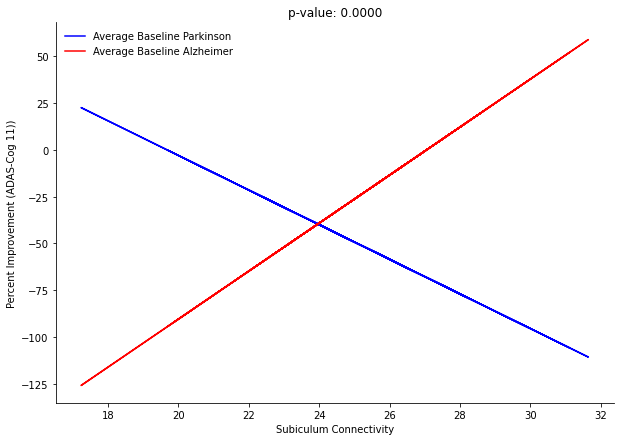

Saved to:  /Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/prospective_planning/redone_joint_dist/create_2D_interaction_plot.svg
Saved to:  /Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Research/2023/subiculum_cognition_and_age/figures/Figures/prospective_planning/redone_joint_dist


In [41]:
fig = create_2D_interaction_plot(data_df.copy(), 
                                 x_one={'Subiculum Connectivity': 'Subiculum_Connectivity_T_Redone'}, 
                                 x_two={'Age': 'Age'}, 
                                 outcome={'Percent Improvement (ADAS-Cog 11))': 'Percent_Cognitive_Improvement'}, 
                                 results=results,
                                 x_values=values_to_test,
                                 legend_labels=['Average Baseline Parkinson', 'Average Baseline Alzheimer'])
save_fig(fig, out_dir)
print('Saved to: ', out_dir)

Significance Testing

In [ ]:
from tqdm import tqdm

def permute_outcome_and_get_proportions_fixed(data_df, 
                                              x_one, x_one_under_mean, x_one_over_mean, x_one_split_point,
                                              x_two, x_two_under_mean, x_two_over_mean, x_two_split_point,
                                              response, binarize=True):
    """
    Function to perform permutation testing on the outcome and compute the proportion of permuted means 
    greater than observed means for both x_one and x_two.
    
    Parameters
    ----------
    data_df : pandas.DataFrame
        The dataframe containing the data.
    x_one, x_two : str
        Column names of the two factors.
    x_one_under_mean, x_two_under_mean : str
        Labels to be used when the values of x_one and x_two are under the mean, respectively.
    x_one_over_mean, x_two_over_mean : str
        Labels to be used when the values of x_one and x_two are over the mean, respectively.
    x_one_split_point, x_two_split_point: int
        Value to split the data of x by.
    response : str
        Column name of the outcome variable.
    binarize : bool
        Whether to convert x_one and x_two into binary variables.

    Returns
    -------
    tuple
        Proportion of permuted means greater than observed mean for x_one and x_two.
    """
    
    # Copy the data
    df_copy = data_df.copy()
    
    # Binarize the variables to get observed values
    if binarize:
        if x_two_split_point is not None:
            df_copy[x_two] = np.where(df_copy[x_two] <= x_two_split_point, 0, 1)
        else:
            df_copy[x_two] = np.where(df_copy[x_two] <= df_copy[x_two].mean(), 0, 1)
        
        if x_one_split_point is not None:
            df_copy[x_one] = np.where(df_copy[x_one] <= x_one_split_point, 0, 1)
        else:
            df_copy[x_one] = np.where(df_copy[x_one] <= df_copy[x_one].mean(), 0, 1)
    
    #Observed Values between within a level of x_one across levels of x_two
    delta_x_one_low = df_copy[response][(df_copy[x_one]==0) & (df_copy[x_two]==0)].mean() - df_copy[response][(df_copy[x_one]==0) & (df_copy[x_two]==1)].mean()
    delta_x_one_high = df_copy[response][(df_copy[x_one]==1) & (df_copy[x_two]==0)].mean() - df_copy[response][(df_copy[x_one]==1) & (df_copy[x_two]==1)].mean()    
    #Empiric Values
    delta_x_one_low_list = []
    delta_x_one_high_list = []
    
    #Observed Values between within a level of x_two across levels of x_one
    delta_x_two_low = df_copy[response][(df_copy[x_two]==0) & (df_copy[x_one]==0)].mean() - df_copy[response][(df_copy[x_two]==0) & (df_copy[x_one]==1)].mean()
    delta_x_two_high = df_copy[response][(df_copy[x_two]==1) & (df_copy[x_one]==0)].mean() - df_copy[response][(df_copy[x_two]==1) & (df_copy[x_one]==1)].mean()    
    #Empiric Values
    delta_x_two_low_list = []
    delta_x_two_high_list = []
    
    
    # Permute outcome and calculate means
    for _ in tqdm(range(10000)):
        permuted_data = data_df.copy()
        permuted_data[response] = np.random.permutation(permuted_data[response].values)
        
            # Binarize the variables to get observed values
        if binarize:
            if x_two_split_point is not None:
                permuted_data[x_two] = np.where(permuted_data[x_two] <= x_two_split_point, 0, 1)
            else:
                permuted_data[x_two] = np.where(permuted_data[x_two] <= permuted_data[x_two].mean(), 0, 1)
            
            if x_one_split_point is not None:
                permuted_data[x_one] = np.where(permuted_data[x_one] <= x_one_split_point, 0, 1)
            else:
                permuted_data[x_one] = np.where(permuted_data[x_one] <= permuted_data[x_one].mean(), 0, 1)
        
        #Observed Values
        delta_x_one_low_list.append(permuted_data[response][(permuted_data[x_one]==0) & (permuted_data[x_two]==0)].mean() - permuted_data[response][(permuted_data[x_one]==0) & (permuted_data[x_two]==1)].mean())
        delta_x_one_high_list.append(permuted_data[response][(permuted_data[x_one]==1) & (permuted_data[x_two]==0)].mean() - permuted_data[response][(permuted_data[x_one]==1) & (permuted_data[x_two]==1)].mean())
        delta_x_two_low_list.append(permuted_data[response][(permuted_data[x_two]==0) & (permuted_data[x_one]==0)].mean() - permuted_data[response][(permuted_data[x_two]==0) & (permuted_data[x_one]==1)].mean())
        delta_x_two_high_list.append(permuted_data[response][(permuted_data[x_two]==1) & (permuted_data[x_one]==0)].mean() - permuted_data[response][(permuted_data[x_two]==1) & (permuted_data[x_one]==1)].mean())
        
    
    x_one_proportion_level1 = np.mean(np.array(delta_x_one_low_list) > delta_x_one_low)
    x_one_proportion_level2 = np.mean(np.array(delta_x_one_high_list) > delta_x_one_high)
    x_two_proportion_level1 = np.mean(np.array(delta_x_two_low_list) > delta_x_two_low)
    x_two_proportion_level2 = np.mean(np.array(delta_x_two_high_list) > delta_x_two_high)
    
    return x_one_proportion_level1, x_one_proportion_level2, x_two_proportion_level1, x_two_proportion_level2

In [ ]:
# Running the fixed function
x_one='Age'; x_one_low_label='Young'; x_one_high_label='Old'
x_one_split_point=63

x_two='Subiculum_Connectivity'; x_two_low_label='Low Connectivity'; x_two_high_label='High Connectivity'
x_two_split_point=66

response='outcome'
#----------------------------------------------------------------
x_one_proportion_level1, x_one_proportion_level2, x_two_proportion_level1, x_two_proportion_level2 = permute_outcome_and_get_proportions_fixed(data_df.copy(), 
                 x_one=x_one, x_one_under_mean=x_one_low_label, x_one_over_mean=x_one_high_label, x_one_split_point=x_one_split_point,
                 x_two=x_two, x_two_under_mean=x_two_low_label, x_two_over_mean=x_two_high_label, x_two_split_point=x_two_split_point,
                 response=response)

print(f'Significance of {x_one} between levels of {x_two} is: {x_one_proportion_level1} at the {x_one_low_label} {x_one} and {x_one_proportion_level2} at the {x_one_high_label} {x_one}')
print(f'Significance of {x_two} between levels of {x_one} is: {x_two_proportion_level1} at the {x_two_low_label} {x_two} and {x_two_proportion_level2} at the {x_two_high_label} {x_two}')

## Use response plane to visualize interaction effect
- This models the marginal distribution of variables
- If the model has 2 predictors and 1 response, then choose option A
- If the model has more than 2 predictors, then choose option B. You will need to manually vary across the additional predictors

2 variable method

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.genmod.generalized_linear_model import GLMResults

def plot_residuals(ax, data_df, x_one, x_two, outcome, results):
    """
    Plots actual data points and residuals on the 3D plot.

    Parameters
    ----------
    ax : matplotlib 3D axis
        The 3D axis object to plot on.
    data_df : pd.DataFrame
        Dataframe containing the predictor variables and outcome.
    x_one : str
        Column name of the first predictor variable in the dataframe.
    x_two : str
        Column name of the second predictor variable in the dataframe.
    outcome : str
        Column name of the outcome variable in the dataframe.
    results : GLMResults
        Fitted model used for making predictions.
    """
    # Plot actual data points
    ax.scatter(data_df[x_one], data_df[x_two], data_df[outcome], color='red', s=50)

    # Calculate predicted values and plot residuals
    for _, row in data_df.iterrows():
        x1_val, x2_val, y_val = row[x_one], row[x_two], row[outcome]
        y_pred_val = results.predict(pd.DataFrame({x_one: [x1_val], x_two: [x2_val]}))
        ax.plot([x1_val, x1_val], [x2_val, x2_val], [y_val, y_pred_val], color='blue', linestyle='dashed', linewidth=1)

def create_interaction_plot(data_df: pd.DataFrame,
                            x_one: str,
                            x_two: str,
                            outcome: str,
                            results: GLMResults,
                            num_slices: int = 100,
                            out_dir: str = './',
                            labels: dict = None,
                            residuals=False) -> plt.Figure:
    """
    Creates a 3D plot visualizing the interaction of two predictor variables on the outcome.
    
    Parameters
    ----------
    data_df : pd.DataFrame
        Dataframe containing the predictor variables and outcome.
    x_one : str
        Column name of the first predictor variable in the dataframe.
    x_two : str
        Column name of the second predictor variable in the dataframe.
    outcome : str
        Column name of the outcome variable in the dataframe.
    results : GLMResults
        Fitted model used for making predictions.
    num_slices : int, optional
        Number of slices to create in the 3D grid, default is 100.
    out_dir : str, optional
        Directory to save the output PNG and SVG files, default is the current directory.
        
    Returns
    -------
    plt.Figure
        The created figure.
    """
    
    # Create grid of predictor variable values
    x1 = np.linspace(min(data_df[x_one]), max(data_df[x_one]), num_slices)
    x2 = np.linspace(min(data_df[x_two]), max(data_df[x_two]), num_slices)
    x1v, x2v = np.meshgrid(x1, x2)

    # Set plot style
    sns.set_style('white')
    sns.set_palette('Greys', 1, desat=1)

    # Flattening the matrices to create a DataFrame for prediction
    X_grid = pd.DataFrame({
        x_one: x1v.ravel(),
        x_two: x2v.ravel(),
    })

    # Generate response values for grid
    y_pred = results.predict(X_grid).values.reshape(num_slices, num_slices)

    # Create a new figure for plotting
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    ax.plot_surface(x1v, x2v, y_pred, cmap='Greys', alpha=0.5)
    
    if residuals:
        plot_residuals(ax, data_df, x_one, x_two, outcome, results)

    # Set the axes labels
    format_label = lambda x: ' '.join(word.capitalize() for word in x.split('_'))
    # Set the axes labels
    if labels is not None:
        ax.set_xlabel(labels.get('x', format_label(x_one)))
        ax.set_ylabel(labels.get('y', format_label(x_two)))
        ax.set_zlabel(labels.get('z', format_label(outcome)))
    else:
        ax.set_xlabel(format_label(x_one))
        ax.set_ylabel(format_label(x_two))
        ax.set_zlabel(format_label(outcome))

    # Save the plot as PNG and SVG files
    fig.savefig(os.path.join(out_dir, '2_variable.png'), dpi=300)
    fig.savefig(os.path.join(out_dir, '2_variable.svg'), format='svg')
    print('Saved to file', out_dir)

    return fig, y_pred, np.meshgrid(x1, x2)


In [ ]:
formula

In [ ]:
x = 'Age'
y = 'Subiculum_Connectivity_T_Redone'
z = 'Percent_Cognitive_Improvement'
#----------------------------------------------------------------DO NOT TOUCH THIS!----------------------------------------------------------------
fig, y_pred, X_grid = create_interaction_plot(data_df, 
                        x_one=x, 
                        x_two=y, 
                        outcome=z, 
                        results=results, 
                        out_dir=out_dir, 
                        labels={'x': 'Age', 'y': 'Subiculum Connectivity', 'z': 'Percent Improvement (ADAS-Cog 11)'},
                        residuals=False);

3 Variable Method

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
from statsmodels.genmod.generalized_linear_model import GLMResults
from typing import List
from matplotlib import colors

def create_interaction_gifs(data_df: pd.DataFrame, 
                            x_one: str, 
                            x_two: str, 
                            x_three: str, 
                            outcome: str, 
                            results: GLMResults, 
                            num_slices: int = 100,
                            gif_duration: float = 0.3) -> List[str]:
    """
    Creates gifs visualizing the interaction of predictor variables on the outcome.
    
    Parameters
    ----------
    data_df : pd.DataFrame
        Dataframe containing the predictor variables and outcome.
    x_one : str
        Column name of the first predictor variable in the dataframe.
    x_two : str
        Column name of the second predictor variable in the dataframe.
    x_three : str
        Column name of the third predictor variable in the dataframe.
    outcome : str
        Column name of the outcome variable in the dataframe.
    results : GLMResults
        Fitted model used for making predictions.
    num_slices : int, optional
        Number of slices to create in the gifs, default is 100.
    gif_duration : float, optional
        Duration of each frame in the gif in seconds, default is 0.3.
        
    Returns
    -------
    List[str]
        List of file paths to the created gif files.
    """

    # Check if x_three is binary
    unique_values = data_df[x_three].unique()
    is_binary = len(unique_values) == 2

    # Create grid of predictor variable values
    x1 = np.linspace(min(data_df[x_one]), max(data_df[x_one]), num_slices)
    x2 = np.linspace(min(data_df[x_two]), max(data_df[x_two]), num_slices)
    
    # Set plot style
    sns.set_style('white')
    sns.set_palette('Greys', 1, desat=1)

    gif_paths = []

    if is_binary:
        for x_three_value in unique_values:
            # Flattening the matrices to create a DataFrame for prediction
            X_grid = pd.DataFrame({
                x_one: np.tile(x1, len(x2)),
                x_two: np.repeat(x2, len(x1)),
                x_three: np.ones_like(np.tile(x1, len(x2))) * x_three_value
            })

            # Generate response values for grid
            y_pred = results.predict(X_grid).values.reshape(len(x2), len(x1))

            # Create a new figure for plotting
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            # Plot the surface
            ax.plot_surface(np.tile(x1, (len(x2), 1)), np.repeat(x2[:, np.newaxis], len(x1), axis=1), y_pred, cmap='bwr', alpha=0.8)

            # Set the axes labels
            format_label = lambda x: ' '.join(word.capitalize() for word in x.split('_'))
            ax.set_xlabel(format_label(x_one))
            ax.set_ylabel(format_label(x_two))
            ax.set_zlabel(format_label(outcome))

            # Set the title with the actual value of x_three
            title = f'{x_three} = {x_three_value}'
            ax.set_title(title)

            # Save the plot as an image file
            image_path = f'plot_{x_three}_{x_three_value}.png'
            plt.savefig(image_path, dpi=300)
            gif_paths.append(image_path)
            plt.close()
    else:
        # Flattening the matrices to create a DataFrame for prediction
        x3 = np.linspace(min(data_df[x_three]), max(data_df[x_three]), num_slices)
        x1v, x2v, x3v = np.meshgrid(x1, x2, x3)

        X_grid = pd.DataFrame({
            x_one: x1v.ravel(),
            x_two: x2v.ravel(),
            x_three: x3v.ravel(),
        })

        # Generate response values for grid
        y_pred = results.predict(X_grid).values.reshape(num_slices, num_slices, num_slices)

        # Collect the file paths of images
        image_paths = []

        # Iterating over x3 (third predictor variable) and saving each plot as an image
        for i in range(num_slices):
            x3_slice = np.linspace(min(data_df[x_three]), max(data_df[x_three]), num_slices)[i]

            # Create a new figure for plotting
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            # Plot the surface
            norm = colors.TwoSlopeNorm(vcenter=0)
            ax.plot_surface(x1v[:, :, i], x2v[:, :, i], y_pred[:, :, i], cmap='Greys', alpha=0.8, norm=norm)

            # Set the axes labels
            format_label = lambda x: ' '.join(word.capitalize() for word in x.split('_'))
            ax.set_xlabel(format_label(x_one))
            ax.set_ylabel(format_label(x_two))
            ax.set_zlabel(format_label(outcome))

            # Set the title with the actual value of x_three
            title = f'{x_three} = {x3_slice:.2f}'
            ax.set_title(title)

            # Save the plot as an image file
            image_path = f'plot_slice_{i+1}.png'
            plt.savefig(image_path, dpi=300)
            image_paths.append(image_path)
            plt.close()

        # Create a gif from the image files
        gif_path = f'plots.gif'
        images = [imageio.imread(image_path) for image_path in image_paths]
        imageio.mimsave(gif_path, images, duration=gif_duration)
        gif_paths.append(gif_path)

        # Remove the individual image files
        for image_path in image_paths:
            os.remove(image_path)

    return gif_paths


# Example usage
# gifs = create_interaction_gifs(data_df, 'x_one', 'x_two', 'x_three', 'outcome', results)
# print("GIFs created:", gifs)


In [ ]:
data_df.columns

In [ ]:
x_one = 'Subiculum_Connectivity'
x_two = 'Age' 
x_three = 'Anticorrelated_Memory_Atrophy'
outcome = 'cognitive_improvement'
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
gifs = create_interaction_gifs(data_df, 
                               x_one, 
                               x_two, 
                               x_three, 
                               outcome, 
                               results)
print("GIFs created:", gifs)

4 Variable Method
- 4th variable is expected to be 1-hot encoded here

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
from statsmodels.genmod.generalized_linear_model import GLMResults
from typing import List


def create_interaction_gifs(data_df: pd.DataFrame, 
                            x_one: str, 
                            x_two: str, 
                            x_three: str, 
                            x_four: str, 
                            x_four_dict: dict,
                            outcome: str, 
                            results: GLMResults, 
                            num_slices: int = 100,
                            gif_duration: float = 0.3) -> List[str]:
    """
    Creates gifs visualizing the interaction of predictor variables on the outcome,
    and the effect of a one-hot encoded variable (x_four).
    
    Parameters
    ----------
    data_df : pd.DataFrame
        Dataframe containing the predictor variables and outcome.
    x_one : str
        Column name of the first predictor variable in the dataframe.
    x_two : str
        Column name of the second predictor variable in the dataframe.
    x_three : str
        Column name of the third predictor variable in the dataframe.
    x_four : str
        Column name of the one-hot encoded predictor variable (values should be 0 or 1) in the dataframe.
    x_four_list : list
        List of the x_four variables corresponding to their one hot encoded outcomes.
    outcome : str
        Column name of the outcome variable in the dataframe.
    results : GLMResults
        Fitted model used for making predictions.
    num_slices : int, optional
        Number of slices to create in the gifs, default is 100.
    gif_duration : float, optional
        Duration of each frame in the gif in seconds, default is 0.3.
        
    Returns
    -------
    List[str]
        List of file paths to the created gif files.
    """

    # Set plot style
    sns.set_style('white')
    sns.set_palette('Greys', 1, desat=1)

    gif_paths = []

    # Iterate over x_four values 0 and 1
    for x_four_value in [0, 1]:
        distribution_df = data_df.copy()
        distribution_df = distribution_df[distribution_df['Disease'] == x_four_value]
        # Create grid of predictor variable values
        x1 = np.linspace(min(distribution_df[x_one]), max(distribution_df[x_one]), num_slices)
        x2 = np.linspace(min(distribution_df[x_two]), max(distribution_df[x_two]), num_slices)
        x3 = np.linspace(min(distribution_df[x_three]), max(distribution_df[x_three]), num_slices)
        x1v, x2v, x3v = np.meshgrid(x1, x2, x3)
        
        # Flattening the matrices to create a DataFrame for prediction
        X_grid = pd.DataFrame({
            x_one: x1v.ravel(),
            x_two: x2v.ravel(),
            x_three: x3v.ravel(),
            x_four: np.ones_like(x1v).ravel() * x_four_value
        })

        # Generate response values for grid
        y_pred = results.predict(X_grid).values.reshape(num_slices, num_slices, num_slices)

        # Collect the file paths of images
        image_paths = []

        # Iterating over x3 (third predictor variable) and saving each plot as an image
        for i in range(num_slices):
            x3_slice = np.linspace(min(data_df[x_three]), max(data_df[x_three]), num_slices)[i]
            
            # Create a new figure for plotting
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            # Plot the surface
            ax.plot_surface(x1v[:, :, i], x2v[:, :, i], y_pred[:, :, i], cmap='bwr', alpha=0.8)

            # Set the axes labels
            format_label = lambda x: ' '.join(word.capitalize() for word in x.split('_'))
            ax.set_xlabel(format_label(x_one))
            ax.set_ylabel(format_label(x_two))
            ax.set_zlabel(format_label(outcome))
            
            # Set the title with the actual value of x_three and x_four
            title = f'{x_four_dict[x_four_value]}, {x_three} = {x3_slice:.2f}'
            ax.set_title(title)

            # Save the plot as an image file
            image_path = f'plot_{x_four}_{x_four_dict[x_four_value]}_slice_{i+1}.png'
            plt.savefig(image_path, dpi=300)
            image_paths.append(image_path)
            plt.close()

        # Create a gif from the image files
        gif_path = f'{x_four}_{x_four_dict[x_four_value]}_plots.gif'
        images = [imageio.imread(image_path) for image_path in image_paths]
        imageio.mimsave(gif_path, images, duration=gif_duration)
        gif_paths.append(gif_path)

        # Remove the individual image files
        for image_path in image_paths:
            os.remove(image_path)

    return gif_paths


# Example usage
# gifs = create_interaction_gifs(data_df, 'Subiculum_Connectivity', 'Subiculum_Grey_Matter', 'Age', 'Disease', 'outcome', results)
# print("GIFs created:", gifs)

In [ ]:
data_df

In [ ]:
x_one = 'Subiculum_Connectivity'
x_two = 'Subiculum_Grey_Matter' 
x_three = 'Age'
x_four = 'Disease'
x_four_dict = {1: "Alzheimer's", 0: "Parkinson's"}
outcome = 'cognitive_improvement'
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
gifs = create_interaction_gifs(data_df, 
                               x_one, 
                               x_two, 
                               x_three, 
                               x_four,
                               x_four_dict,
                               outcome, 
                               results)
print("GIFs created:", gifs)

5 Variable Method
- This is identical to the 4 variable method, but takes the 5th variable 
and calculates is at -2 and +2 standard deviations, then plots a response plane for each.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
from statsmodels.genmod.generalized_linear_model import GLMResults
from typing import List


def create_interaction_gifs_with_5_variables(data_df: pd.DataFrame, 
                                             x_one: str, 
                                             x_two: str, 
                                             x_three: str, 
                                             x_four: str, 
                                             x_four_dict: dict,
                                             x_five: str,
                                             x_five_factor_levels: int,
                                             outcome: str, 
                                             results: GLMResults, 
                                             num_slices: int = 100,
                                             gif_duration: float = 0.3) -> List[str]:
    
    # Create grid of predictor variable values
    x1 = np.linspace(min(data_df[x_one]), max(data_df[x_one]), num_slices)
    x2 = np.linspace(min(data_df[x_two]), max(data_df[x_two]), num_slices)
    x3 = np.linspace(min(data_df[x_three]), max(data_df[x_three]), num_slices)
    x1v, x2v, x3v = np.meshgrid(x1, x2, x3)

    # Set plot style
    sns.set_style('white')
    sns.set_palette('Greys', 1, desat=1)

    gif_paths = []

    # Iterate over x_four values 0 and 1
    for x_four_value in [0, 1]:
        
        # Collect the file paths of images
        image_paths = []

        # Iterating over x3 (third predictor variable) and saving each plot as an image
        for i in range(num_slices):
            x3_slice = np.linspace(min(data_df[x_three]), max(data_df[x_three]), num_slices)[i]
            
            # Create a new figure for plotting
            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')

            # Choose to use x_five mean
            x_five_mean = data_df[x_five].mean()
            x_five_std = data_df[x_five].std()
            if x_five_factor_levels == 1:
                x_five_level = [x_five_mean]
            # Choose to use x_five +/- 2 standard deviations
            else:
                x_five_level = [x_five_mean-(2*x_five_std), x_five_mean+(2*x_five_std)]
            for level in range(0, len(x_five_level)):
                
                # Flattening the matrices to create a DataFrame for prediction
                X_grid = pd.DataFrame({
                    x_one: x1v.ravel(),
                    x_two: x2v.ravel(),
                    x_three: x3v.ravel(),
                    x_four: np.ones_like(x1v).ravel() * x_four_value,
                    x_five: np.ones_like(x1v).ravel() * x_five_level[level]
                })

                # Generate response values for grid
                y_pred = results.predict(X_grid).values.reshape(num_slices, num_slices, num_slices)
                
                # Plot the surface
                cmap = 'viridis' if x_five_level[level] == data_df[x_five].mean() else ('cool' if x_five_level[level] < 0 else 'magma')
                ax.plot_surface(x1v[:, :, i], x2v[:, :, i], y_pred[:, :, i], cmap=cmap, alpha=0.5)

            # Set the axes labels
            format_label = lambda x: ' '.join(word.capitalize() for word in x.split('_'))
            ax.set_xlabel(format_label(x_one))
            ax.set_ylabel(format_label(x_two))
            ax.set_zlabel(format_label(outcome))
            
            # Set the title with the actual value of x_three and x_four
            title = f'{x_four_dict[x_four_value]}, {x_three} = {x3_slice:.2f}'
            ax.set_title(title)

            # Save the plot as an image file
            image_path = f'plot_{x_four}_{x_four_dict[x_four_value]}_slice_{i+1}.png'
            plt.savefig(image_path, dpi=300)
            image_paths.append(image_path)
            plt.close()

        # Create a gif from the image files
        gif_path = f'{x_four}_{x_four_dict[x_four_value]}_plots.gif'
        images = [imageio.imread(image_path) for image_path in image_paths]
        imageio.mimsave(gif_path, images, duration=gif_duration)
        gif_paths.append(gif_path)

        # Remove the individual image files
        for image_path in image_paths:
            os.remove(image_path)

    return gif_paths




In [ ]:
x_one = 'Subiculum_Connectivity'
x_two = 'Subiculum_Grey_Matter' 
x_three = 'Age'
x_four = 'Disease'
x_four_dict = {1: "Alzheimer's", 0: "Parkinson's"}
x_five = 'Subiculum_CSF'
x_five_factor_levels = 1
outcome = 'cognitive_improvement'
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
gifs = create_interaction_gifs_with_5_variables(data_df, 
                               x_one, 
                               x_two, 
                               x_three, 
                               x_four,
                               x_four_dict,
                               x_five,
                               x_five_factor_levels,
                               outcome, 
                               results)
print("GIFs created:", gifs)

# Get Inflection Point of Joint Distribution

With Local Maxima/Minima

In [ ]:
import numpy as np
from scipy.signal import argrelextrema

class SaddlePointFinderMaxMin:
    """
    A class to identify saddle points in a 2D array using local maxima and minima method.
    """
    
    def __init__(self, data):
        """
        Initialize the class with the 2D array to be analyzed.

        Parameters:
        data (np.ndarray): 2D array for which the saddle points are to be identified.
        """
        self.data = data
        
    def find_local_minima_maxima(self, array):
        """
        Find local minima and maxima in a 1D array.
        
        Parameters:
        array (np.ndarray): 1D data array
        
        Returns:
        tuple: Indices of local minima and maxima in the array.
        """
        local_minima = argrelextrema(array, np.less)[0]
        local_maxima = argrelextrema(array, np.greater)[0]
        return local_minima, local_maxima
    
    def find_critical_points(self):
        """
        Identify the saddle points in the 2D array using local maxima and minima method.

        Returns:
        list: List of coordinates (as tuples) of the identified saddle points.
        """
        row_minima_coords = []
        row_maxima_coords = []
        for i, row in enumerate(self.data):
            local_minima, local_maxima = self.find_local_minima_maxima(row)
            for coord in local_minima:
                row_minima_coords.append((i, coord))
            for coord in local_maxima:
                row_maxima_coords.append((i, coord))
                
        col_minima_coords = []
        col_maxima_coords = []
        for i, col in enumerate(self.data.T):
            local_minima, local_maxima = self.find_local_minima_maxima(col)
            for coord in local_minima:
                col_minima_coords.append((coord, i))
            for coord in local_maxima:
                col_maxima_coords.append((coord, i))
        
        saddle_points = list(set(row_minima_coords).intersection(col_maxima_coords) | set(row_maxima_coords).intersection(col_minima_coords))
        
        return saddle_points


In [ ]:
# Test the class with the given data
finder = SaddlePointFinderMaxMin(y_pred)
finder.find_critical_points()

With Gradients

In [ ]:
from scipy.signal import argrelextrema
from matplotlib import colors 

class GradientCriticalPointFinder:
    """
    A class to identify and visualize the approximate critical points in a 2D array using gradient-based methods.
    """

    def __init__(self, data_array, out_dir=None):
        """
        Initialize the GradientCriticalPointFinder with the 2D array to be analyzed.

        Parameters:
        data_array (np.ndarray): 2D array for which the critical points are to be identified.
        """
        self.data_array = data_array
        self.gradient_x = None
        self.gradient_y = None
        self.combined_gradient_abs = None
        self.critical_points = None
        self.out_dir = out_dir

    def _compute_gradients(self):
        """
        Computes the gradients for each dimension of the data array.
        """
        self.gradient_x = np.gradient(self.data_array, axis=0)
        self.gradient_y = np.gradient(self.data_array, axis=1)
        combined_gradient = self.gradient_x * self.gradient_y
        self.combined_gradient_abs = np.abs(combined_gradient)

    def set_indices_to_one(self, zero_array, row_indices, col_indices):
        for r, c in zip(row_indices, col_indices):
            zero_array[r, c] = 1
        return zero_array
    
    def _identify_critical_points(self, use_absolute_minima=False):
        """
        Identify the approximate critical points by finding intersections between the minima of gradient_x and gradient_y.
        """
        gradient_x_min = np.zeros_like(self.gradient_x)
        gradient_y_min = np.zeros_like(self.gradient_y)

        if use_absolute_minima:
            # Find the index of the global minimum in each column for gradient_x
            for i in range(0, self.gradient_x.shape[0]):
                gradient_x_min[i, :] = np.where(self.gradient_x[i,:] == np.min(self.gradient_x[i,:]), 1, 0)
                
            # Find the index of the global minimum in each row for gradient_y
            for i in range(0, self.gradient_y.shape[1]):
                gradient_y_min[:, i] = np.where(self.gradient_y[:,i] == np.min(self.gradient_y[:,i]), 1, 0)

        # Find coincident hits
        critical_points_array = gradient_x_min * gradient_y_min
        
        # At the end of the method:
        rows, cols = np.where(critical_points_array == 1)
        self.critical_points = (rows, cols)
        print('Critical points found at rows:', self.critical_points[0], 'cols:', self.critical_points[1])


    def plot(self, use_absolute_minima=False):
        """
        Generate the required plots.
        """
        # Ensure gradients are computed
        if self.gradient_x is None or self.gradient_y is None:
            self._compute_gradients()

        # Identify critical points
        self._identify_critical_points(use_absolute_minima)

        self.fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        norm = colors.TwoSlopeNorm(vcenter=0)
    
        # Plot gradients with the norm applied
        cax1 = axes[0].imshow(self.gradient_x, cmap='bwr', origin='lower', norm=norm)
        axes[0].set_title("Gradient X")
        plt.colorbar(cax1, ax=axes[0], orientation='vertical')

        cax2 = axes[1].imshow(self.gradient_y, cmap='bwr', origin='lower', norm=norm)
        axes[1].set_title("Gradient Y")
        plt.colorbar(cax2, ax=axes[1], orientation='vertical')

        # Plot absolute value of the multiplied gradients
        cax3 = axes[2].imshow(self.combined_gradient_abs, cmap='bwr', origin='lower', norm=norm)
        axes[2].set_title("Abs(Gradient X * Gradient Y)")
        plt.colorbar(cax3, ax=axes[2], orientation='vertical')
        
        # Plot data_array with critical points and the norm applied
        cax4 = axes[3].imshow(self.data_array, cmap='bwr', origin='lower', norm=norm)
        if len(self.critical_points[0]) > 0:
            axes[3].scatter(self.critical_points[1], self.critical_points[0], color='black', marker='X', label='Critical Point')
        axes[3].set_title("Function with Critical Points")
        plt.colorbar(cax4, ax=axes[3], orientation='vertical')

        plt.legend()
        plt.tight_layout()
        plt.show()
            
    def get_critical_points(self):
        """
        Return the coordinates of the identified critical points.
        """
        return self.critical_points
    
    def save_figure(self):
        """
        Save the figure stored in self.figure to a file.

        Parameters:
        filename (str): The name of the file to save the figure as (e.g., 'figure.png').
        """
        if self.out_dir is not None:
            # Save the plot as PNG and SVG files
            self.fig.savefig(os.path.join(out_dir, 'gradient.png'), dpi=300)
            self.fig.savefig(os.path.join(out_dir, 'gradient.svg'), format='svg')
            print('Saved to file', out_dir)
            
    def run(self):
        '''
        Run method.
        '''
        self.plot(use_absolute_minima=True)
        self.get_critical_points()
        self.save_figure()
        
    
finder = GradientCriticalPointFinder(y_pred, out_dir=out_dir).run()

Stable

In [ ]:
from scipy.signal import argrelextrema

class GradientCriticalPointFinder:
    """
    A class to identify and visualize the approximate critical points in a 2D array using gradient-based methods.
    """

    def __init__(self, data_array):
        """
        Initialize the GradientCriticalPointFinder with the 2D array to be analyzed.

        Parameters:
        data_array (np.ndarray): 2D array for which the critical points are to be identified.
        """
        self.data_array = data_array
        self.gradient_x = None
        self.gradient_y = None
        self.combined_gradient_abs = None
        self.critical_points = None

    def _compute_gradients(self):
        """
        Computes the gradients for each dimension of the data array.
        """
        self.gradient_x = np.gradient(self.data_array, axis=0)
        self.gradient_y = np.gradient(self.data_array, axis=1)

    def _identify_critical_points(self):
        """
        Identify the approximate critical points using element-wise multiplication and rounding.
        """
        combined_gradient = self.gradient_x * self.gradient_y
        self.combined_gradient_abs = np.abs(combined_gradient)
        
        # Find local minima
        local_minima = argrelextrema(self.combined_gradient_abs, np.less)
        self.critical_points = local_minima

    def plot(self):
        """
        Generate the required plots.
        """
        # Ensure gradients are computed
        if self.gradient_x is None or self.gradient_y is None:
            self._compute_gradients()

        # Identify critical points
        if self.critical_points is None:
            self._identify_critical_points()

        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        norm = colors.TwoSlopeNorm(vcenter=0)
    
        # Plot gradients with the norm applied
        cax1 = axes[0].imshow(self.gradient_x, cmap='bwr', origin='lower', norm=norm)
        axes[0].set_title("Gradient X")
        plt.colorbar(cax1, ax=axes[0], orientation='vertical')

        cax2 = axes[1].imshow(self.gradient_y, cmap='bwr', origin='lower', norm=norm)
        axes[1].set_title("Gradient Y")
        plt.colorbar(cax2, ax=axes[1], orientation='vertical')

        # Plot absolute value of the multiplied gradients
        cax3 = axes[2].imshow(self.combined_gradient_abs, cmap='bwr', origin='lower', norm=norm)
        axes[2].set_title("Abs(Gradient X * Gradient Y)")
        plt.colorbar(cax3, ax=axes[2], orientation='vertical')
        
        # Plot data_array with critical points and the norm applied
        cax4 = axes[3].imshow(self.data_array, cmap='bwr', origin='lower', norm=norm)
        axes[3].scatter(self.critical_points[1], self.critical_points[0], color='black', marker='X', label='Critical Point')
        axes[3].set_title("Function with Critical Points")
        plt.colorbar(cax4, ax=axes[3], orientation='vertical')

        plt.legend()
        plt.tight_layout()
        plt.show()

    def get_critical_points(self):
        """
        Return the coordinates of the identified critical points.
        """
        if self.critical_points is None:
            self._identify_critical_points()
        
        return self.critical_points
finder = GradientCriticalPointFinder(y_pred)
finder.plot()
finder.get_critical_points()

In [ ]:
#X_Grid[0] corresponds to the x-axis, and this derives the value of it at the gradient min.
#In your experiements, this is generally age. 
print(X_grid[0][42, 58]) #<---row is the 0 value in gradient y, col is the 0 value in gradient x
#X_Grid[1] corresponds to the z-axis, and this derives the value of it at the gradient min
print(X_grid[1][42, 58])

Use the Hessian discriminant

In [ ]:
class HessianSaddlePointFinder:
    """
    A class to identify the saddle points in a 2D array.
    """

    def __init__(self, y_pred):
        """
        Initialize the SaddlePointFinder with the 2D array to be analyzed.

        Parameters:
        y_pred (np.ndarray): 2D array for which the saddle points are to be identified.
        """
        self.y_pred = y_pred

    def _compute_derivatives(self):
        """
        Computes the first order partial derivatives with respect to both dimensions.

        Returns:
        tuple: First order partial derivatives with respect to x and y dimensions.
        """
        dy_d1 = np.gradient(self.y_pred, axis=0)
        dy_d2 = np.gradient(self.y_pred, axis=1)
        
        return dy_d1, dy_d2

    def _compute_second_mixed_derivatives(self):
        """
        Computes the second order partial derivatives and both mixed partial derivatives.

        Returns:
        tuple: Second order partial derivatives with respect to x and y dimensions, and both mixed partial derivatives.
        """
        dy_d1, dy_d2 = self._compute_derivatives()
        
        # Second order partial derivative with respect to x dimension (rows)
        d2y_d1_2 = np.gradient(dy_d1, axis=0)
        
        # Second order partial derivative with respect to y dimension (columns)
        d2y_d2_2 = np.gradient(dy_d2, axis=1)
        
        # Mixed partial derivatives
        d2y_d1d2 = np.gradient(dy_d1, axis=1)
        d2y_d2d1 = np.gradient(dy_d2, axis=0)
        
        return d2y_d1_2, d2y_d2_2, d2y_d1d2, d2y_d2d1

    def find_saddle_points(self):
        """
        Identify the saddle points in the 2D array.

        Returns:
        tuple: Coordinates of the saddle point or (None, None) if no saddle point exists.
        """
        second_deriv_1, second_deriv_2, mixed_deriv_1, mixed_deriv_2 = self._compute_second_mixed_derivatives()
        
        # Check equivalence of mixed partial derivatives
        if not np.allclose(mixed_deriv_1, mixed_deriv_2):
            return "Error: Mixed partial derivatives are not equivalent."
        
        # Calculate D
        D = second_deriv_1 * second_deriv_2 - mixed_deriv_1**2
        
        # Identify saddle points
        saddle_points = np.where(D < 0)
        
        print('Saddle points found at coordinates:')
        print(np.min(D))
        if saddle_points[0].size == 0:
            return None, None
        else:
            return saddle_points[0][0], saddle_points[1][0]

Test proof of saddle point idenfitication

In [ ]:
# Let's test the final class with the sample_array
z = np.linspace(0,10,100)
x = z 

# Create the grid of coordinates
xv, zv = np.meshgrid(x,z)

# Calculate y at every coordinate set
sample_array = xv**2 - zv**2

# Identify the single saddle point, which should be at 0,0
saddle_finder_final = SaddlePointFinderFinal(sample_array)
saddle_coordinates_final = saddle_finder_final.find_saddle_points()
saddle_coordinates_final

Find Saddle Point of Your Array of Interest

In [ ]:
saddle_finder_final = SaddlePointFinderFinal(y_pred)
saddle_coordinates_final = saddle_finder_final.find_saddle_points()
saddle_coordinates_final

In [ ]:
y_pred[saddle_coordinates_final[0], saddle_coordinates_final[1]]

In [ ]:
y_pred.shape
from numpy import savetxt
import os
savetxt(os.path.join(out_dir,'y_pred.csv'), y_pred, delimiter=',')
print('saved to: ', os.path.join(out_dir,'y_pred.csv'))

In [ ]:
X_grid.to_numpy().shape

print(X_grid.to_numpy()[saddle_coordinates_final[0], 0])
print(X_grid.to_numpy()[saddle_coordinates_final[1], 1])

## Comparison Within Joint Distribution

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import scipy.stats as stats
from tqdm import tqdm

def compute_statistics_and_create_dataframe(resampled_metrics, observed_metric, test_type, test_tails='two_tailed'):
    """
    Compute p-value and confidence interval and organize them in a DataFrame.
    
    :param resampled_metrics: List of metrics computed from the resampled or permuted data
    :param observed_metric: Observed metric computed from the original data
    :param comparison_method: Method for comparing responses ('correlation' or 'point_testing')
    :param test_type: Type of test performed ('resampling' or 'permutation')
    :param test_tails: Type of tail for p-value testing ('two_tailed', 'right_tailed', or 'left_tailed')
    :return: DataFrame with p-value and confidence interval
    """
    # Calculate p-value and confidence interval for low and high values
    if test_type =='permutation':
        if test_tails == 'two_tailed':
            print('Two-tailed p-value testing')
            p_value_low = np.mean(np.abs([x[0] for x in resampled_metrics]) >= np.abs(observed_metric[0]))
            p_value_high = np.mean(np.abs([x[1] for x in resampled_metrics]) >= np.abs(observed_metric[1]))
        elif test_tails == 'right_tailed':
            print('Right-tailed p-value testing')
            p_value_low = np.mean([x[0] for x in resampled_metrics] >= observed_metric[0])
            p_value_high = np.mean([x[1] for x in resampled_metrics] >= observed_metric[1])
        elif test_tails == 'left_tailed':
            print('Left-tailed p-value testing.')
            p_value_low = np.mean([x[0] for x in resampled_metrics] <= observed_metric[0])
            p_value_high = np.mean([x[1] for x in resampled_metrics] <= observed_metric[1])
        else:
            raise ValueError("Invalid value for test_tails. Must be one of 'two_tailed', 'right_tailed', or 'left_tailed'.")
    elif test_type == 'resampling':
        p_value_low = np.mean(np.sign(np.mean([x[0] for x in resampled_metrics])) != np.sign(observed_metric[0]))
        p_value_high = np.mean(np.sign(np.mean([x[1] for x in resampled_metrics])) != np.sign(observed_metric[1]))
    else:
        raise ValueError(f"Test type is not supported: {test_type}")
    
    conf_int_low = np.percentile([x[0] for x in resampled_metrics], [2.5, 97.5])
    conf_int_high = np.percentile([x[1] for x in resampled_metrics], [2.5, 97.5])

    # Create DataFrame
    data = {
        'Observed Metric': [observed_metric[0], observed_metric[1]],
        'P-value': [p_value_low, p_value_high],
        '95% CI Lower': [conf_int_low[0], conf_int_high[0]],
        '95% CI Upper': [conf_int_low[1], conf_int_high[1]]
    }
    index = ['Delta Y pred indep_var_2 +/- stdev holding indep_var_1 at -2stdev', 
                'Delta Y pred indep_var_2 +/- stdev holding indep_var_1 at +2stdev']

    return pd.DataFrame(data, index=[index])


def compare_responses(df, dependent_var, independent_var1, independent_var2, interaction=True):
    """
    Compare responses of a dataset using point testing method.
    
    :param df: DataFrame containing the dataset
    :param dependent_var: Name of the dependent variable
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param interaction: Boolean indicating if interaction between independent variables should be considered
    :param test_tails: Type of tail for p-value testing ('two_tailed', 'right_tailed', or 'left_tailed')
    :return: Comparison metric (absolute differences between low and high points)
    """
    if interaction:
        formula = f'{dependent_var} ~ {independent_var1} * {independent_var2}'
    else:
        formula = f'{dependent_var} ~ {independent_var1} + {independent_var2}'

    # Fit the model
    model = smf.ols(formula=formula, data=df).fit()

    # Evaluate at specific points
    diff_low, diff_high = evaluate_at_specific_points(df, independent_var1, independent_var2, model)

    # Return the absolute differences
    return abs(diff_low), abs(diff_high)

def evaluate_at_specific_points(df, independent_var1, independent_var2, model):
    """
    Evaluate the model at specific points.
    
    :param df: DataFrame containing the dataset
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param model: Fitted model
    :return: Differences between low and high points
    """
    # Determine the low and high values of the independent variables
    iv1_sd = data_df[independent_var1].std()
    iv2_sd = data_df[independent_var2].std()
    iv1_mean = data_df[independent_var1].mean()
    iv2_mean = data_df[independent_var2].mean()

    # Create the dataframes for low_1 and high_1 predictions
    low_1_df = pd.DataFrame({
        independent_var1: iv1_mean - 2 * iv1_sd,
        independent_var2: [iv2_mean - 2 * iv2_sd, iv2_mean + 2 * iv2_sd]
    })

    high_1_df = pd.DataFrame({
        independent_var1: iv1_mean + 2 * iv1_sd,
        independent_var2: [iv2_mean - 2 * iv2_sd, iv2_mean + 2 * iv2_sd]
    })

    # Perform the predictions on the dataframes
    low_1_predictions = model.predict(low_1_df)
    high_1_predictions = model.predict(high_1_df)

    # Calculate the differences between the predictions
    difference_low = low_1_predictions[1] - low_1_predictions[0]
    difference_high = high_1_predictions[1] - high_1_predictions[0]

    return difference_low, difference_high

def resample_or_permutation_test(df, dependent_var, independent_var1, independent_var2, interaction=True, num_resamples=1000, test_type='permutation', test_tails='two_tails'):
    """
    Perform resampling or permutation test to compare responses of two datasets and return results in a DataFrame.
    
    :param df: DataFrame containing the dataset
    :param dependent_var: Name of the dependent variable
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param interaction: Boolean indicating if interaction between independent variables should be considered
    :param comparison_method: Method for comparing responses ('correlation' or 'point_testing')
    :param num_slices: Number of values to take for each variable to form the grid (used in correlation)
    :param num_resamples: Number of resamples to perform
    :param test_type: Type of test to perform ('resampling' or 'permutation')
    :return: p-value and confidence interval
    """
    # Calculate observed metric
    observed_metric = compare_responses(df, dependent_var, independent_var1, independent_var2, interaction)
    
    # Initialize results
    resampled_metrics = []

    for i in tqdm(range(num_resamples)):
        # Perform resampling or permutation
        if test_type == 'resampling':
            sample_df = df.sample(frac=1, replace=True)
        elif test_type == 'permutation':
            sample_df = df.copy()
            sample_df[dependent_var] = np.random.permutation(sample_df[dependent_var].values)
        else:
            raise ValueError("test_type must be either 'resampling' or 'permutation'.")
        
        # Calculate resampled metric
        resampled_metric = compare_responses(sample_df, dependent_var, independent_var1, independent_var2, interaction)
        resampled_metrics.append(resampled_metric)
    
    # Calculate statistics and create DataFrame
    results_dataframe = compute_statistics_and_create_dataframe(resampled_metrics, observed_metric, test_type, test_tails=test_tails)
    
    return results_dataframe


In [ ]:
data_df

In [ ]:
#Define dataframe 1 and dataframe 2 for comaprison by permutation test
df_1 = data_df[data_df['Disease'] == 1]
df_2 = data_df[data_df['Disease'] == 0]
dependent_var = 'outcome'
independent_var1 = 'Age'
independent_var2 = 'Subiculum_Connectivity'
enable_interaction = True
num_iterations = 10000
test_tails = 'two_tailed'
#:param test_tails: Type of tail for p-value testing ('two_tailed', 'right_tailed', or 'left_tailed')
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
permutation_results = resample_or_permutation_test(df = df_1,
                                                    dependent_var = dependent_var,
                                                    independent_var1 = independent_var1,
                                                    independent_var2 = independent_var2,
                                                    interaction = enable_interaction,
                                                    num_resamples=num_iterations, 
                                                    test_type='permutation',
                                                    test_tails=test_tails)
permutation_results

In [ ]:
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
bootstrap_results = resample_or_permutation_test(df = df_2,
                                                    dependent_var = dependent_var,
                                                    independent_var1 = independent_var1,
                                                    independent_var2 = independent_var2,
                                                    interaction = enable_interaction,
                                                    num_resamples=num_iterations, 
                                                    test_type='resampling')
bootstrap_results

## Comparison Between Joint Distributions

**Comparison of 2 Joint Distributions**
1) Joint Distributions and Multiple Regression:

The concept of "joint distributions" refers to the combined distribution of multiple variables, taking into account their mutual relationships. In the context of multiple regression analysis, we utilize a statistical model to examine the joint distribution of the independent variables and their relationship with the dependent variable. By fitting a regression model, such as the one used in this code, we can investigate how the independent variables collectively influence the dependent variable.

In the provided code, we compare the responses of two datasets based on their joint distributions. This means that we analyze the relationship between the independent variables (independent_var1 and independent_var2) as a pair and their collective influence on the dependent variable. We fit separate regression models for each dataset, considering both independent variables as predictors and the dependent variable as the response.

Analyzing the joint distributions allows us to gain insights into how the independent variables interact with each other and jointly impact the dependent variable. By considering the joint relationship between the variables, we can understand how changes in one independent variable may affect the response when the other independent variable is also taken into account.

2) Permutation vs Bootstrap:

The code employs two different approaches for hypothesis testing: permutation testing and bootstrap resampling. Both methods aim to assess the significance of the observed metrics by generating alternative datasets.

Permutation testing involves randomly permuting the values of the dependent variable while keeping the independent variables unchanged. This process breaks the relationship between the dependent and independent variables, creating new datasets under the assumption of no association. By comparing the observed metric with metrics obtained from the permuted datasets, we can estimate p-values and confidence intervals, providing a measure of the statistical significance of our results. A permuted dataset is one wherein the independent variables are unrelated to the dependent variable. They are the null distribution. 

Bootstrap resampling, on the other hand, involves randomly sampling data points from the original datasets with replacement. This resampling process allows us to create multiple datasets of the same size as the original datasets. By generating new datasets through resampling, we can examine the distribution of the metrics of interest and estimate their variability. This information can be used to estimate confidence intervals and assess the statistical significance of our findings. A bootstrap resampling process creates alternative datasets wherein the independent variables are still related to the dependent variable. These define significance by demonstrating the confidence intervals of the dataset do not cross a threshold, which is typically 0.

3) Correlation vs Point-test:

The code provides two different methods for comparing responses based on the joint distributions: correlation and point testing.

The correlation analysis aims to assess the spatial correlation between the joint distributions of the two datasets. This analysis examines the overall patterns and similarities in the responses across the range of the joint distributions. By calculating the correlation coefficient between the predicted responses, we can determine if there is a consistent relationship between the joint distributions of the independent variables and the dependent variable across the datasets. Then, we compare this to bootstrapped or permuted datasets to derive significance estimates.

In contrast, point testing focuses on evaluating the differences in the predicted responses at specific points of the joint distributions. Specifically, we examine the differences at +/- 2 standard deviations of the independent variables. This analysis allows us to determine if the differences between the responses at these specific points significantly vary between the two datasets. By comparing the differences in response values at these critical points, we can identify regions of the joint distributions where the relationship between the independent variables and the dependent variable differs significantly. The purpose of this is to condense a 3-dimensional joint distribution into 2-dimensions at set values which is good for generating figures. Then, we compare this to bootstrapped or permuted datasets to derive significance estimates.

In summary, comparing the joint distributions enables us to analyze the combined effects of the independent variables on the dependent variable. The correlation and point testing methods offer different perspectives on the relationship between the variables, while permutation testing and bootstrap resampling provide means to assess the statistical significance of our findings.

**Instructions**
Testing: 'correlation' or 'point_testing'
Significance Testing: 'permutation' or 'resampling'

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as stats
from tqdm import tqdm

def compute_statistics_and_create_dataframe(resampled_metrics, observed_metric, comparison_method, test_type, test_tails='right_tailed'):
    """
    Compute p-value and confidence interval and organize them in a DataFrame.
    
    :param resampled_metrics: List of metrics computed from the resampled or permuted data
    :param observed_metric: Observed metric computed from the original data
    :param comparison_method: Method for comparing responses ('correlation' or 'point_testing')
    :return: DataFrame with p-value and confidence interval
    """
    if comparison_method == 'correlation':
        # Calculate p-value and confidence interval
        p_value = np.mean(np.abs(resampled_metrics) >= np.abs(observed_metric))
        conf_int = np.percentile(resampled_metrics, [2.5, 97.5])

        # Create DataFrame
        data = {
            'Observed Metric': [observed_metric],
            'P-value': [p_value],
            '95% CI Lower': [conf_int[0]],
            '95% CI Upper': [conf_int[1]]
        }
        index = 'Spatial correlation of the joint distributions'
    
    elif comparison_method == 'point_testing':
        # Calculate p-value and confidence interval for low and high values
        if test_type =='permutation':
            if test_tails == 'two_tailed':
                print('Two-tailed p-value testing')
                p_value_low = np.mean(np.abs([x[0] for x in resampled_metrics]) >= np.abs(observed_metric[0]))
                p_value_high = np.mean(np.abs([x[1] for x in resampled_metrics]) >= np.abs(observed_metric[1]))
            elif test_tails == 'right_tailed':
                print('Right-tailed p-value testing')
                p_value_low = np.mean([x[0] for x in resampled_metrics] >= observed_metric[0])
                p_value_high = np.mean([x[1] for x in resampled_metrics] >= observed_metric[1])
            elif test_tails == 'left_tailed':
                print('Left-tailed p-value testing.')
                p_value_low = np.mean([x[0] for x in resampled_metrics] <= observed_metric[0])
                p_value_high = np.mean([x[1] for x in resampled_metrics] <= observed_metric[1])
            else:
                raise ValueError("Invalid value for test_tails. Must be one of 'two_tailed', 'right_tailed', or 'left_tailed'.")
        elif test_type == 'resampling':
            p_value_low = np.mean(np.sign(np.mean([x[0] for x in resampled_metrics])) != (np.sign(np.mean([x[0] for x in resampled_metrics]))))
            p_value_high = np.mean(np.sign(np.mean([x[1] for x in resampled_metrics])) != (np.sign(np.mean([x[1] for x in resampled_metrics]))))
        else:
            raise ValueError (f'Test type is not supported {test_type}')
        conf_int_low = np.percentile(resampled_metrics[0], [2.5, 97.5])
        conf_int_high = np.percentile(resampled_metrics[1], [2.5, 97.5])

        # Create DataFrame
        data = {
            'Observed Metric': [observed_metric[0], observed_metric[1]],
            'P-value': [p_value_low, p_value_high],
            '95% CI Lower': [conf_int_low[0], conf_int_high[0]],
            '95% CI Upper': [conf_int_low[1], conf_int_high[1]]
        }
        index = ['Delta Y pred indep_var_2 +/- stdev holding indep_var_1 at -2stdev', 
                 'Delta Y pred indep_var_2 +/- stdev holding indep_var_1 at +2stdev']

    else:
        raise ValueError("comparison_method must be either 'correlation' or 'point_testing'.")

    return pd.DataFrame(data, index=[index])


def calculate_predicted_response(data_df, independent_var1, independent_var2, model, num_slices=100):
    """
    Calculate predicted response values for a grid of values of two independent variables.
    
    :param data_df: DataFrame containing data
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param model: Fitted model
    :param num_slices: Number of values to take for each variable to form the grid
    :return: Flattened array of predicted responses
    """
    x1 = np.linspace(min(data_df[independent_var1]), max(data_df[independent_var1]), num_slices)
    x2 = np.linspace(min(data_df[independent_var2]), max(data_df[independent_var2]), num_slices)
    x1v, x2v = np.meshgrid(x1, x2)

    X_grid = pd.DataFrame({
        independent_var1: x1v.ravel(),
        independent_var2: x2v.ravel(),
    })

    y_pred = model.predict(X_grid).values.reshape(num_slices, num_slices)

    return y_pred.ravel()

def evaluate_at_specific_points(data_df, independent_var1, independent_var2, model):
    """
    Evaluate the model at specific points: +/- 2 standard deviations of the independent variables.

    :param data_df: DataFrame containing data
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param model: Fitted model
    :return: Differences between the predictions at specific points
    """
    iv1_sd = data_df[independent_var1].std()
    iv2_sd = data_df[independent_var2].std()
    iv1_mean = data_df[independent_var1].mean()
    iv2_mean = data_df[independent_var2].mean()

    # Create the dataframes for low_1 and high_1 predictions
    low_1_df = pd.DataFrame({
        independent_var1: iv1_mean - 2 * iv1_sd,
        independent_var2: [iv2_mean - 2 * iv2_sd, iv2_mean + 2 * iv2_sd]
    })

    high_1_df = pd.DataFrame({
        independent_var1: iv1_mean + 2 * iv1_sd,
        independent_var2: [iv2_mean - 2 * iv2_sd, iv2_mean + 2 * iv2_sd]
    })

    # Perform the predictions on the dataframes
    low_1_predictions = model.predict(low_1_df)
    high_1_predictions = model.predict(high_1_df)

    # Calculate the differences between the predictions
    difference_low = low_1_predictions[1] - low_1_predictions[0]
    difference_high = high_1_predictions[1] - high_1_predictions[0]

    return difference_low, difference_high

def compare_responses(df1, df2, dependent_var, independent_var1, independent_var2, interaction=True, comparison_method='correlation', num_slices=100):
    """
    Compare responses of two datasets using correlation or point testing method.
    
    :param df1: DataFrame containing first dataset
    :param df2: DataFrame containing second dataset
    :param dependent_var: Name of the dependent variable
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param interaction: Boolean indicating if interaction between independent variables should be considered
    :param comparison_method: Method for comparing responses ('correlation' or 'point_testing')
    :param num_slices: Number of values to take for each variable to form the grid (used in correlation)
    :return: Comparison metric
    """
    if interaction:
        formula = f'{dependent_var} ~ {independent_var1} * {independent_var2}'
    else:
        formula = f'{dependent_var} ~ {independent_var1} + {independent_var2}'

    # Fit the models
    model1 = smf.ols(formula=formula, data=df1).fit()
    model2 = smf.ols(formula=formula, data=df2).fit()

    if comparison_method == 'correlation':
        # Calculate predicted responses
        response_1 = calculate_predicted_response(df1, independent_var1, independent_var2, model1, num_slices)
        response_2 = calculate_predicted_response(df2, independent_var1, independent_var2, model2, num_slices)

        # Calculate correlation between the predicted responses
        return stats.pearsonr(response_1, response_2)[0]

    elif comparison_method == 'point_testing':
        # Evaluate at specific points
        diff_low_1, diff_high_1 = evaluate_at_specific_points(df1, independent_var1, independent_var2, model1)
        diff_low_2, diff_high_2 = evaluate_at_specific_points(df2, independent_var1, independent_var2, model2)
        
        # Return the absolute differences
        return abs(diff_low_1 - diff_low_2), abs(diff_high_1 - diff_high_2)

    else:
        raise ValueError("comparison_method must be either 'correlation' or 'point_testing'.")

# Update the resample_or_permutation_test function
def resample_or_permutation_test(df1, df2, dependent_var, independent_var1, independent_var2, interaction=True, comparison_method='correlation', num_slices=100, num_resamples=1000, test_type='permutation'):
    """
    Perform resampling or permutation test to compare responses of two datasets and return results in a DataFrame.
    
    :param df1: DataFrame containing first dataset
    :param df2: DataFrame containing second dataset
    :param dependent_var: Name of the dependent variable
    :param independent_var1: Name of the first independent variable
    :param independent_var2: Name of the second independent variable
    :param interaction: Boolean indicating if interaction between independent variables should be considered
    :param comparison_method: Method for comparing responses ('correlation' or 'point_testing')
    :param num_slices: Number of values to take for each variable to form the grid (used in correlation)
    :param num_resamples: Number of resamples to perform
    :param test_type: Type of test to perform ('resampling' or 'permutation')
    :return: p-value and confidence interval
    """
    # Calculate observed metric
    observed_metric = compare_responses(df1, df2, dependent_var, independent_var1, independent_var2, interaction, comparison_method, num_slices)
    
    # Initialize results
    resampled_metrics = []

    for i in tqdm(range(num_resamples)):
        # Perform resampling or permutation
        if test_type == 'resampling':
            sample_df1 = df1.sample(frac=1, replace=True)
            sample_df2 = df2.sample(frac=1, replace=True)
        elif test_type == 'permutation':
            sample_df1 = df1.copy()
            sample_df2 = df2.copy()
            sample_df1[dependent_var] = np.random.permutation(sample_df1[dependent_var].values)
            sample_df2[dependent_var] = np.random.permutation(sample_df2[dependent_var].values)
        else:
            raise ValueError("test_type must be either 'resampling' or 'permutation'.")
        
        # Calculate resampled metric
        resampled_metric = compare_responses(sample_df1, sample_df2, dependent_var, independent_var1, independent_var2, interaction, comparison_method, num_slices)
        resampled_metrics.append(resampled_metric)
    
    # Calculate statistics and create DataFrame
    results_dataframe = compute_statistics_and_create_dataframe(resampled_metrics, observed_metric, comparison_method, test_type)
    
    return results_dataframe, resampled_metrics, observed_metric


In [ ]:
data_df.columns

In [ ]:
#Define dataframe 1 and dataframe 2 for comaprison by permutation test
df_1 = data_df[data_df['Cohort'] == 1]
df_2 = data_df[data_df['Cohort'] == 2]
dependent_var = 'Percent_Cognitive_Improvement'
independent_var1 = 'Subiculum_Connectivity'
independent_var2 = 'Cognitive_Baseline'
enable_interaction = True
num_iterations = 10000
comparison_method = 'correlation' 

In [ ]:
data_df

Permutation Test It

In [ ]:
# while (permutation_results.loc[:,'P-value'] > 0.05).any():
permutation_results,  empiric_distribution, observed_metric = resample_or_permutation_test(df1 = df_1,
                                                            df2 = df_2,
                                                            dependent_var = dependent_var,
                                                            independent_var1 = independent_var1,
                                                            independent_var2 = independent_var2,
                                                            interaction = enable_interaction,
                                                            test_type = 'permutation',
                                                            comparison_method = comparison_method,
                                                            num_resamples = num_iterations)
permutation_results

Bootstrap Test It

In [ ]:
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
bootstrap_results, empiric_distribution, observed_metric = resample_or_permutation_test(df1 = df_1,
                                                            df2 = df_2,
                                                            dependent_var = dependent_var,
                                                            independent_var1 = independent_var1,
                                                            independent_var2 = independent_var2,
                                                            interaction = enable_interaction,
                                                            test_type = 'resampling',
                                                            comparison_method = comparison_method,
                                                            num_resamples = num_iterations)
bootstrap_results

Plot the Histogram 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class DeltaCorrelation():
    def __init__(self, data_df):
        self.empiric_dist = None
        self.observed_val = None

    def set_empiric_and_observed(self, empiric_dist, observed_val):
        self.empiric_dist = empiric_dist
        self.observed_val = observed_val

    def plot_kde_histogram(self, bins=50, one_tail=False, color_palette='dark'):
        if self.empiric_dist is None or self.observed_val is None:
            print("Empiric distribution and observed value must be set before plotting.")
            return

        if one_tail:
            empiric_dist = np.abs(self.empiric_dist)
            observed_val = np.abs(self.observed_val)
        else:
            empiric_dist = self.empiric_dist
            observed_val = self.observed_val

        p_value = np.mean(empiric_dist >= observed_val)

        sns.set_palette(color_palette)
        current_palette = sns.color_palette(color_palette)
        chosen_color = current_palette[3]

        g = sns.displot(empiric_dist, kde=True, bins=bins, label="Empirical Distribution", element="step", color='blue', alpha=.25)
        g.fig.set_size_inches(6.5, 4.5)
        plt.axvline(x=observed_val, color='red', linestyle='-', linewidth=1.5, label=f"Observed Value", alpha=1)
        plt.title(f"Spatial Correlation = {observed_val:.2f}, p = {p_value:.4f}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()

        fig = g.fig

        fig.savefig(f"{out_dir}/kde_histogram.png", bbox_inches='tight')
        fig.savefig(f"{out_dir}/kde_histogram.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/kde_histogram.svg')


In [ ]:
hist = DeltaCorrelation(data_df)
hist.set_empiric_and_observed(empiric_dist=empiric_distribution, observed_val=observed_metric)
hist.plot_kde_histogram()

**Find the Inflection in Arbitrary Number of Distributions**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import minimize
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import os
from calvin_utils.statistical_utils.distribution_statistics import plot_with_annotation
from scipy.stats import ks_2samp


class SaddlePointFinder:
    """
    This class finds the saddle points in a linear regression model with interaction terms.
    It uses the coefficients of the model as the first partial derivatives of the function with respect to each variable.
    The class identifies points in the data where these partial derivatives are minimized, which are treated as saddle points.
    
    Note: 
    The approach is heuristic and not rigorous. It assumes that the coefficients can serve as good approximations
    for the first partial derivatives, which may not always be the case. Therefore, the identified saddle points 
    are approximate and should be interpreted with caution.
    """
    def __init__(self, dependent_var, independent_var1, independent_var2, num_resamples=1000):
        """
        Initialize the SaddlePointFinder with variable names and resampling details.
        
        Parameters:
        - dependent_var (str): The dependent variable in the formula.
        - independent_var1, independent_var2 (str): The independent variables in the formula.
        - num_resamples (int): The number of bootstrapping samples.
        """
        self.dependent_var = dependent_var
        self.independent_var1 = independent_var1
        self.independent_var2 = independent_var2
        self.num_resamples = num_resamples

    def find_saddle_point(self, model, sample_df):
        """
        Find the values of the regressors at the saddle point in a single model.
        
        Parameters:
        - model: A fitted OLS model.
        - sample_df: The DataFrame containing the sampled data.
        
        Returns:
        - A tuple containing the saddle point values for the independent variables.
        """
        coef_x1 = model.params.get(self.independent_var1, 0)
        coef_x2 = model.params.get(self.independent_var2, 0)
        coef_interaction = model.params.get(f"{self.independent_var1}:{self.independent_var2}", 0)

        sample_df.reset_index(drop=True, inplace=True)

        y2 = coef_x1 + coef_interaction * sample_df[self.independent_var2]
        index_min_y2 = np.argmin(np.abs(y2))
        x2 = sample_df.loc[index_min_y2, self.independent_var2]

        y1 = coef_x2 + coef_interaction * sample_df[self.independent_var1]
        index_min_y1 = np.argmin(np.abs(y1))
        x1 = sample_df.loc[index_min_y1, self.independent_var1]

        return (x1, x2)

    def resample_and_find_saddle_points(self, df):
        """
        Perform bootstrapping to find approximate saddle points in the model.
        
        Parameters:
        - df (DataFrame): The DataFrame containing the variables.
        
        Returns:
        - DataFrame containing the saddle points for the independent variables.
        """
        saddle_points = []
        for _ in tqdm(range(self.num_resamples)):
            sample_df = df.sample(frac=1, replace=True)
            formula = f"{self.dependent_var} ~ {self.independent_var1} * {self.independent_var2}"
            model = ols(formula=formula, data=sample_df).fit()
            saddle_point = self.find_saddle_point(model, sample_df)
            saddle_points.append(saddle_point)
        return pd.DataFrame(saddle_points, columns=[self.independent_var1, self.independent_var2])

    def run_multiple_dfs(self, df_list):
        """
        Run the saddle point finder on multiple DataFrames.
        
        Parameters:
        - df_list (list): List of DataFrames.
        
        Returns:
        - List of DataFrames, each containing the saddle points for the corresponding input DataFrame.
        """
        results = []
        for df in df_list:
            result = self.resample_and_find_saddle_points(df)
            results.append(result)
        return results
    
    def perform_t_tests_and_plots(self, df_dict, x_label='x', y_label='y', test_type='t-test_ind',  out_dir=None, colours=['red', 'blue']):
        """
        Perform t-tests and generate plots for pairs of DataFrames.

        Parameters:
        - df_dict (dict): Dictionary containing DataFrame as key and its new column name as value.
        - x_label (str): X-axis label for the plot.
        - y_label (str): Y-axis label for the plot.
        - test_type (str): Type of statistical test to perform.
        - out_dir (str): Directory to save the output plots.
        - colours (list): List of colours for the plot.

        Returns:
        - None
        """

        df_list = list(df_dict.values())
        col_name_list = list(df_dict.keys())

        for i, df1 in enumerate(df_list[:-1]):
            for j, df2 in enumerate(df_list[i+1:]):
                
                col1_new = col_name_list[i]
                col2_new = col_name_list[i+j+1]
                
                df1_renamed = df1.rename(columns={df1.columns[0]: col1_new})
                df2_renamed = df2.rename(columns={df2.columns[0]: col2_new})

                merged_df = pd.concat([df1_renamed[[col1_new]], df2_renamed[[col2_new]]], keys=[col1_new, col2_new], names=['Group', 'None']).reset_index(level=0).rename(columns={'Group': 'Group', 0: 'Value'})
                
                plt = plot_with_annotation(dataframe=merged_df, 
                                        col1=col1_new, 
                                        col2=col2_new,
                                        xlabel=x_label, 
                                        ylabel=y_label, 
                                        test_type=test_type,
                                        colours=colours)
                if out_dir is not None:
                    os.makedirs(os.path.join(out_dir, 'distribution_figures'), exist_ok=True)
                    plt.savefig(os.path.join(out_dir, f'distribution_figures/{x_label}_{test_type}_{y_label}.png'))
                    plt.savefig(os.path.join(out_dir, f'distribution_figures/{x_label}_{test_type}_{y_label}.svg'))
                    print(f'Figure saved to: {os.path.join(out_dir, f"distribution_figures/{x_label}_{test_type}_{y_label}")}')
                plt.show()

def plot_95CI(df_dict, x_label='x', y_label='y', out_dir=None, colours=['red', 'blue']):
    """
    Plot the 95% confidence intervals for each DataFrame using seaborn boxplot.

    Parameters:
    - df_dict (dict): Dictionary containing DataFrame as key and its new column name as value.
    - x_label (str): X-axis label for the plot.
    - y_label (str): Y-axis label for the plot.
    - out_dir (str): Directory to save the output plots.
    - colours (list): List of colours for the plot.

    Returns:
    - None
    """
    # Prepare data for seaborn
    aggregated_data = []
    for label, df in df_dict.items():
        df['label'] = label
        aggregated_data.append(df)

    concatenated_df = pd.concat(aggregated_data)
    concatenated_df.columns = [y_label, x_label]

    # Create the boxplot
    fig, ax = plt.subplots()
    sns.boxplot(x=x_label, y=y_label, data=concatenated_df, ax=ax, palette=colours, whis=[2.5, 97.5])

    # Labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'Distribution of {y_label} At Inflection Point')


    # Save plot
    if out_dir is not None:
        os.makedirs(os.path.join(out_dir, '95CI_figures'), exist_ok=True)
        plt.savefig(os.path.join(out_dir, f'95CI_figures/{x_label}_{y_label}.png'))
        plt.savefig(os.path.join(out_dir, f'95CI_figures/{x_label}_{y_label}.svg'))
        print(f'Figure saved to: {os.path.join(out_dir, f"95CI_figures/{x_label}_{y_label}")}')
    
    plt.show()
    
def run_ks_test(df_dict):
    """
    Run a Kolmogorov-Smirnov test on two datasets to determine if their distributions are significantly different.

    Parameters:
    - df_dict (dict): Dictionary containing two DataFrames as key-value pairs.

    Returns:
    - p_value (float): p-value from the KS test.
    """
    if len(df_dict) != 2:
        return "The dictionary should contain exactly two datasets."
    
    data_1, data_2 = list(df_dict.values())
    
    # Extracting the single column from each DataFrame
    data_1_column = data_1.iloc[:, 0]
    data_2_column = data_2.iloc[:, 0]
    
    # Running the KS test
    _, p_value = ks_2samp(data_1_column, data_2_column)
    
    return p_value 

Define your Variables

In [ ]:
data_df.columns

In [ ]:
dependent_var = 'Z_Scored_Percent_Cognitive_Improvement'
independent_var1 = 'Age'
independent_var2 = 'Subiculum_Connectivity'
num_resamples=10000

Initialize the Class

In [ ]:
saddle_finder = SaddlePointFinder(dependent_var=dependent_var, independent_var1=independent_var1, independent_var2=independent_var2, num_resamples=num_resamples)

**Option A) Run a Single Dataframe**

In [ ]:
result = saddle_finder.resample_and_find_saddle_points(data_df)
result

**Option B) Run Multiple Dataframes**
- Enter as many as you want into a list

In [ ]:
df_1 = data_df[data_df['Cohort'] == 1]
df_2 = data_df[data_df['Cohort'] == 0]

In [ ]:
df_list = [df_1, df_2]
result = saddle_finder.run_multiple_dfs(df_list)

**Visualize the Distributions**

In [ ]:
print(result)

**Plot 95% CI**

Option A) 1 Dataframe

In [ ]:
df_1_label = 'Boston'
value_of_interest = 'Subiculum_Connectivity'
y_label = 'Y'
x_label = 'X'

In [ ]:
df_dict = {df_1_label: result.loc[:, [value_of_interest]]}

Option B) Multiple Dataframes

In [ ]:
df_1_label = 'Alzheimer'
df_2_label = 'Parkinson'
value_of_interest = 'Age'
y_label = 'Age'
x_label = 'Disease'

In [ ]:
df_dict = {df_1_label: results[0].loc[:, [value_of_interest]], df_2_label: results[1].loc[:, [value_of_interest]]}


Visualize

In [ ]:
plot_95CI(df_dict=df_dict, x_label=x_label, y_label=y_label, out_dir='/Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/analyses/saddle_point', colours=['red', 'blue'])
run_ks_test(df_dict)

Plot Distribution and Test Distribution

In [ ]:
results[0].loc[:, [value_of_interest]].std()

In [ ]:
'Mann-Whitney'

In [ ]:
df_dict = {df_1_label: results[0].loc[:, [value_of_interest]], df_2_label: results[1].loc[:, [value_of_interest]]}
saddle_finder.perform_t_tests_and_plots(df_dict=df_dict, x_label=x_label, y_label=y_label, out_dir='/Users/cu135/Dropbox (Partners HealthCare)/studies/cognition_2023/analyses/saddle_point', colours=['red', 'blue'], test_type='t-test_ind')

# See If Two Regressions Are Significantly Different

In [ ]:
# Import necessary libraries (if you haven't already)
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from tqdm import tqdm

class RegressionComparison:
    def __init__(self, df, dependent_var, independent_vars, split_var, split_value, constant_value_for_second_predictor=np.nan):
        """
        Initialize the RegressionComparison object with data and variable names.
        """
        self.df1 = df[df[split_var] <= split_value]
        self.df2 = df[df[split_var] > split_value]
        self.dependent_var = dependent_var
        self.independent_vars = independent_vars
        self.formula = f"{dependent_var} ~ {' + '.join(independent_vars)}"
        self.constant_value_for_second_predictor=constant_value_for_second_predictor
        if self.df1.empty or self.df2.empty:
            raise ValueError("One of the datasets is empty after the split. Check your split variable and value.")
    
    def fit_models(self):
        """
        Fit OLS regression models for each dataset.
        """
        self.model1 = smf.ols(formula=self.formula, data=self.df1).fit()
        self.model2 = smf.ols(formula=self.formula, data=self.df2).fit()
        
    def create_evaluation_dataframe(self, n_points=100):
        """
        Create a DataFrame for evaluation with different ranges for the first predictor
        and a constant value for the second predictor.
        
        :param constant_value_for_second_predictor: The constant value to set for the second predictor.
        :param n_points: Number of points where the model will be evaluated.
        :return: Two DataFrames for evaluation, one for each dataset.
        """
        
        # For the first dataset
        x_values_df1 = np.linspace(min(self.df1[self.independent_vars[0]]), 
                                max(self.df1[self.independent_vars[0]]), n_points)
        eval_df1 = pd.DataFrame({self.independent_vars[0]: x_values_df1})
        eval_df1[self.independent_vars[1]] = self.constant_value_for_second_predictor
        
        # For the second dataset
        x_values_df2 = np.linspace(min(self.df2[self.independent_vars[0]]), 
                                max(self.df2[self.independent_vars[0]]), n_points)
        eval_df2 = pd.DataFrame({self.independent_vars[0]: x_values_df2})
        eval_df2[self.independent_vars[1]] = self.constant_value_for_second_predictor
        
        return eval_df1, eval_df2


    def calculate_observed_delta(self, n_points=100):
        """
        Calculate the observed delta between the two regression models for 100 datapoints.
        """
        self.x_df1, self.x_df2 = self.create_evaluation_dataframe()

        pred1 = self.model1.predict(self.x_df1)
        pred2 = self.model2.predict(self.x_df2)

        self.observed_delta = np.sum(pred1 - pred2)
        

    def permute_outcomes(self):
        """Permute the dependent variable in df1 and df2."""
        permuted_y1 = np.random.permutation(self.df1[self.dependent_var].values)
        permuted_y2 = np.random.permutation(self.df2[self.dependent_var].values)

        perm_df1 = self.df1.copy()
        perm_df2 = self.df2.copy()

        perm_df1[self.dependent_var] = permuted_y1
        perm_df2[self.dependent_var] = permuted_y2

        return perm_df1, perm_df2


    def calculate_empirical_delta(self, n_permutations=1000, n_points=100):
        """Calculate the empirical delta using permuted data."""
        self.empirical_deltas = []

        for _ in tqdm(range(n_permutations)):
            # Step 1: Permute the outcomes
            perm_df1, perm_df2 = self.permute_outcomes()

            # Step 2: Fit models on permuted data
            model1 = smf.ols(formula=self.formula, data=perm_df1).fit()
            model2 = smf.ols(formula=self.formula, data=perm_df2).fit()

            # Step 3: Create evaluation DataFrames for permuted data
            x_df1, x_df2 = self.create_evaluation_dataframe(n_points)

            # Step 4: Make predictions on evaluation DataFrames
            pred1 = model1.predict(x_df1)
            pred2 = model2.predict(x_df2)

            # Step 5: Calculate and store empirical delta
            empirical_delta = np.sum(pred1 - pred2)
            self.empirical_deltas.append(empirical_delta)

    def calculate_significance(self):
        """
        Calculate the p-value based on empirical deltas.
        """
        mask = self.empirical_deltas >= self.observed_delta
        self.p_value = np.mean(mask)
        
        return self.p_value

    def run(self, n_permutations=1000, n_points=100):
        """
        Orchestrates the complete pipeline.
        
        :param n_permutations: Number of permutations for empirical delta calculation.
        :param n_points: Number of points to use in observed delta calculation.
        """
        
        # Step 1: Fit the models
        self.fit_models()
        
        # Step 2: Create evaluation DataFrames
        self.x_df1, self.x_df2 = self.create_evaluation_dataframe(n_points)
        
        # Step 3: Calculate observed delta
        self.calculate_observed_delta(n_points)
        
        # Step 4: Calculate empirical delta
        self.calculate_empirical_delta(n_permutations)
        
        # Step 5: Calculate significance
        p_value = self.calculate_significance()
        
        return p_value



Punch In Your Data

In [ ]:
# Define variables based on your specific case
dependent_var = 'Z_Scored_Cognitive_Improvement_By_Group'
independent_vars = ['Subiculum_Connectivity', 'Age']
split_var = 'Cohort'
split_value = 0.5
value_to_set_to = 67

Run It

In [ ]:
# Initialize the class with the variables
reg_comp = RegressionComparison(df=data_df, 
                                dependent_var=dependent_var, 
                                independent_vars=independent_vars, 
                                split_var=split_var, 
                                split_value=split_value, 
                                constant_value_for_second_predictor=value_to_set_to)

# Fit the models
p = reg_comp.run()
print("Significance Count:", p)

## Generate a Fancy Response Tensor

In [ ]:
from calvin_utils.import_matrices import import_matrices_from_folder
from calvin_utils.generate_nifti import nifti_from_matrix
from nimlab import datasets as nimds
import numpy as np
from nilearn import image, plotting, maskers

#Name variables to plot
var_one = 'Limbic'
var_two = 'Ventral_Attention'
val_var_two = 65.4

#get conectivity values of interest
matrix_path = '/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/seed_generated_networks/yeo_networks_from_thick_yeo_seeds/all_05_limbic_T.nii'
matrix = import_matrices_from_folder(matrix_path, file_pattern='')

#get conectivity values of interest
matrix_path_2 = '/Users/cu135/Dropbox (Partners HealthCare)/memory/functional_networks/seed_generated_networks/yeo_networks_from_thick_yeo_seeds/all_04_ventral_attention_T.nii'
matrix_2 = import_matrices_from_folder(matrix_path, file_pattern='')


#------------------------------------------------------------------------------------------------DO NOT MODIFY!------------------------------------------------------------------------------------------------
#Set reression input values into a dataframe
input_df = pd.DataFrame()
input_df[var_one] = matrix.iloc[:,0]
input_df[var_two] = matrix_2.iloc[:,0]

from nimlab import datasets as nimds
mni_mask = nimds.get_img("mni_icbm152")
mask_data = mni_mask.get_fdata().flatten()
brain_indices = np.where(mask_data > 0)[0]
input_df = input_df.iloc[brain_indices, :]

#Standardize matrix via z score
from calvin_utils.z_score_matrix import z_score_matrix
for col in input_df.columns:
    input_df.loc[:, col] = z_score_matrix(input_df.loc[:, col])

#Display results
display(input_df)


In [ ]:
import tqdm
#Generate a new matrix from the input dataframe
responses = []

#Work on a voxel-wise basis by iterating over index
for i in tqdm.tqdm(range(0, len(input_df))):
    #Do not calculate on zero values as intercept will be applied in the regressoin
    if np.sum(input_df.iloc[i,0]) != 0:
        #Assign a temporary dataframe with values that the statsmodels model is expecting
        temp_df = pd.DataFrame({var_one: input_df.iloc[i,0], var_two: input_df.iloc[i,1]}, index=['temp_vals'])
        #Calculate the voxelwise predicted outcome at a given voxel
        responses.append(results.predict(temp_df)[0])
    else:
        #If voxel is zero-connectivity, assign zero so as to avoid application of intercept
        responses.append(0)
        
#Store responses in a dataframe
response_df = pd.DataFrame()
response_df['response_topology'] = responses
display(response_df)

In [ ]:

#Place back in brain mask
mask_data[brain_indices] = response_df.loc[:, 'response_topology']
response_toplogy = mask_data

In [ ]:
from calvin_utils.generate_nifti import view_and_save_nifti
matrix_img = view_and_save_nifti(response_toplogy, out_dir)
matrix_img

## Data Driven Search for Most Relevant Regressors
Combines:
- All possible subsets regression combined with leave-one-out cross validation
- Identifies formula with lowest RMSE and highest Pearson Correlation of predictor to observed outcome values
- Presents the optimal formulas and allows selection of which formula to interpret with structural analysis and coefficient analysis

In [ ]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm

def generate_interaction_terms(df, predictors, max_interaction_level=3):
    interaction_df = df[predictors].copy()

    def add_interaction_terms(df, columns, interaction_level):
        if interaction_level == 1:
            return df

        for col_combination in itertools.combinations(columns, interaction_level):
            interaction_term = ':'.join(col_combination)
            interaction_values = np.prod(df[list(col_combination)], axis=1)
            df[interaction_term] = interaction_values

        return add_interaction_terms(df, columns, interaction_level - 1)

    return add_interaction_terms(interaction_df, predictors, max_interaction_level)

def loocv_regression(df, interaction_df, formula, outcome_var):
    full_df = interaction_df.copy()
    full_df[outcome_var] = df[outcome_var]
    model = sm.formula.ols(formula, data=full_df).fit()
    y_actual, y_predicted = [], []
    
    for i in range(len(df)):
        x_test = interaction_df.iloc[[i]]
        x_train = interaction_df.drop(i)
        y_train = df[outcome_var].drop(i)
        
        model_train_df = x_train.join(y_train)
        model_train = sm.formula.ols(formula, data=model_train_df).fit()
        y_actual.append(df[outcome_var].iloc[i])
        y_predicted.append(model_train.predict(x_test).values[0])
    
    rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
    corr, _ = pearsonr(y_actual, y_predicted)
    return rmse, corr

def all_subsets_regression(df, outcome_var):
    predictor_columns = [col for col in df.columns if col != outcome_var]
    interaction_df = generate_interaction_terms(df, predictor_columns, max_interaction_level=3)

    results = []
    for n_predictors in tqdm(range(1, len(predictor_columns) + 1)):
        for predictor_combination in itertools.combinations(predictor_columns, n_predictors):
            formula = f"{outcome_var} ~ {' + '.join(predictor_combination)}"
            loocv_rmse, loocv_corr = loocv_regression(df, interaction_df, formula, outcome_var)

            results.append({
                'formula': formula,
                'rmse': loocv_rmse,
                'correlation': loocv_corr
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by='correlation', ascending=False, inplace=True)
    results_df.reset_index(drop=True, inplace=True)
    return results_df


def all_subsets_regression_no_loocv(df, outcome_var):
    predictor_columns = [col for col in df.columns if col != outcome_var]

    results = []
    for n_predictors in tqdm(range(1, len(predictor_columns) + 1)):
        for predictor_combination in itertools.combinations(predictor_columns, n_predictors):
            formula = f"{outcome_var} ~ {' + '.join(predictor_combination)}"
            model = sm.formula.ols(formula, data=df).fit()

            y_actual = df[outcome_var].values
            y_predicted = model.predict(df[predictor_columns])

            rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
            corr, _ = pearsonr(y_actual, y_predicted)

            results.append({
                'formula': formula,
                'rmse': rmse,
                'correlation': corr
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by='correlation', ascending=False, inplace=True)
    results_df.reset_index(drop=True, inplace=True)
    return results_df

In [ ]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm


def all_subsets_regression(df, outcome_var, limit_to_two_way_interactions=False, max_predictors=None):
    predictor_columns = [col for col in df.columns if col != outcome_var]

    results = []
    for n_predictors in tqdm(range(1, min(max_predictors + 1, len(predictor_columns) + 1))):
        for predictor_combination in itertools.combinations(predictor_columns, n_predictors):
            # Check whether to limit interactions to two-way
            if limit_to_two_way_interactions and n_predictors > 1:
                # Generate combinations for two-way interactions
                interaction_combinations = itertools.combinations(predictor_combination, 2)
                interaction_terms = [' : '.join(interaction) for interaction in interaction_combinations]
                # Include both individual predictors and interaction terms
                formula = f"{outcome_var} ~ {' + '.join(predictor_combination)} + {' + '.join(interaction_terms)}"
            else:
                # Original formula generation with all possible interactions
                formula = f"{outcome_var} ~ {' * '.join(predictor_combination)}"
            
            print(formula)
            loocv_rmse, loocv_corr = loocv_regression(df, formula, outcome_var)

            results.append({
                'formula': formula,
                'rmse': loocv_rmse,
                'correlation': loocv_corr
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by='correlation', ascending=False, inplace=True)
    results_df.reset_index(drop=True, inplace=True)
    return results_df


def loocv_regression(df, formula, outcome_var):
    model = sm.formula.ols(formula, data=df).fit()
    y_actual, y_predicted = [], []

    for i in range(len(df)):
        index_label = df.index[i]
        x_test = df.iloc[[i]].drop(outcome_var, axis=1)
        x_train = df.drop(index_label).drop(outcome_var, axis=1)
        y_train = df[outcome_var].drop(index_label)

        model_train_df = x_train.join(y_train)
        model_train = sm.formula.ols(formula, data=model_train_df).fit()
        y_actual.append(df[outcome_var].iloc[i])
        y_predicted.append(model_train.predict(x_test).values[0])

    rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
    corr, _ = pearsonr(y_actual, y_predicted)
    return rmse, corr


# Example usage:
# df = pd.read_csv('your_data.csv')
# outcome_var = 'your_outcome_variable'
# results_df = all_subsets_regression(df, outcome_var)
# print(results_df.head())

In [ ]:
outcome_var = 'outcome'
limit_to_two_way_interactions = False
regressor_limit = 3
#----------------------------------------------------------------DO NOT TOUCH----------------------------------------------------------------
df = data_df.copy()
results_df = all_subsets_regression(df, outcome_var, limit_to_two_way_interactions=limit_to_two_way_interactions, max_predictors=regressor_limit)
display(results_df)

In [ ]:
print('Top 20 formulas by Correlation of y-hat to y')
pd.set_option('display.max_colwidth', None)
results_df.head(20)

In [ ]:
print('Top 20 formulas by RMSE of y-hat to y')
# Sort DataFrame by 'rmse' in ascending order
rmse_df = results_df.copy().sort_values(by='rmse', ascending=True)

# Display the sorted DataFrame
rmse_df.head(20)

In [ ]:
# Printing top 5 formulas

top_five_formulas = results_df.head(5)['formula']
print("Top 5 Formulas:")
print(top_five_formulas)


print('---Lowest RMSE Information---')
index_of_min_rmse = results_df['rmse'].idxmin()
print(results_df.loc[index_of_min_rmse, 'formula'])
print('RMSE: ',results_df.loc[index_of_min_rmse, 'rmse'])
print('Pearson R: ', results_df.loc[index_of_min_rmse, 'correlation'])
print('Formula index: ', index_of_min_rmse)

print('\n---Highest Correlation Information---')
index_of_max_corr = results_df['correlation'].idxmax()
print(results_df.loc[index_of_max_corr, 'formula'])
print('RMSE: ',results_df.loc[index_of_max_corr, 'rmse'])
print('Pearson R: ', results_df.loc[index_of_max_corr, 'correlation'])
print('Formula index: ', index_of_max_corr)


In [ ]:
import statsmodels.formula.api as smf
formula_to_test = 6
#----------------------------------------------------------------
results = smf.ols(results_df.loc[formula_to_test, 'formula'], data=df).fit()
# results = smf.ols('percent_change_adascog11 ~ Subiculum*Age*total_hippocampal_csf*frontal', data=data_df).fit()


print(results.summary2())

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import model_diagnostics
model_diagnostics(results)

## Find the Optimal Interaction Subset of Optimal Model by Backward Regression

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import itertools


def backward_subsets_loocv_regression(df, formula):
    # Extract outcome_var from the formula
    outcome_var = formula.split(' ~ ')[0].strip()
    
    y_actual, y_predicted = [], []

    for i in range(len(df)):
        index_label = df.index[i]
        x_test = df.iloc[[i]].drop(outcome_var, axis=1)
        x_train = df.drop(index_label).drop(outcome_var, axis=1)
        y_train = df[outcome_var].drop(index_label)

        model_train_df = x_train.join(y_train)
        model_train = smf.ols(formula, data=model_train_df).fit()
        y_actual.append(df[outcome_var].iloc[i])
        y_predicted.append(model_train.predict(x_test).values[0])

    rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
    corr, _ = pearsonr(y_actual, y_predicted)
    return rmse, corr


def serial_interaction_removal_loocv(df, formula):
    # Split the formula into the left and right side
    left, right = formula.split("~")
    
    # Get all the terms from the right side of the formula
    terms = right.strip().split("*")
    terms = [term.strip() for term in terms]
    
    # Generate all combinations of + and *
    operators_combinations = itertools.product(["+", "*"], repeat=len(terms)-1)
    
    # Generate the formulas
    formulas = []
    for operators in operators_combinations:
        combined_formula = left + " ~ " + terms[0]
        for op, term in zip(operators, terms[1:]):
            combined_formula += " " + op + " " + term
        formulas.append(combined_formula.strip())

    # Run LOOCV on each formula
    loocv_results = []
    for sub_formula in formulas:
        loocv_rmse, loocv_corr = backward_subsets_loocv_regression(df, sub_formula)
        loocv_results.append({
            'formula': sub_formula,
            'rmse': loocv_rmse,
            'correlation': loocv_corr
        })
    
    # Convert results to DataFrame, sort by correlation and reset index
    loocv_results_df = pd.DataFrame(loocv_results)
    loocv_results_df.sort_values(by='correlation', ascending=False, inplace=True)
    loocv_results_df.reset_index(drop=True, inplace=True)

    return loocv_results_df


# Example usage:
# Assuming `df` is your DataFrame, and `formula` is a string like "y ~ a * b * c"
# best_formula = "y ~ a * b * c"
# serial_loocv_df = serial_interaction_removal_loocv(df, best_formula)
# print(serial_loocv_df)

best_formula = results_df.loc[formula_to_test, 'formula']
optimal_interaction_loocv_df = serial_interaction_removal_loocv(df, best_formula)
optimal_interaction_loocv_df.head(20)

# Structural Coefficient Analysis of Optimal Model

In [ ]:
import patsy

def structural_coefficients(model, data):
    # Extracting the predictor names
    predictor_names = model.model.exog_names
    if 'Intercept' in predictor_names:
        predictor_names.remove('Intercept')

    # Calculating the predicted values
    y_predicted = model.predict(data)

    # Creating a temporary dataframe to store interaction terms
    temp_df = pd.DataFrame()
    
    for pred in predictor_names:
        # Check if the predictor is an interaction term
        if ':' in pred:
            # Split the interaction term into its components
            components = pred.split(':')
            # Multiply the components and store the result in the temporary dataframe
            temp_product = data[components[0]]
            for component in components[1:]:
                temp_product *= data[component]
            temp_df[pred] = temp_product
        else:
            temp_df[pred] = data[pred]

    # Calculating the structural coefficients
    structural_coefs = {}
    for pred in predictor_names:
        coef, _ = pearsonr(temp_df[pred], y_predicted)
        structural_coefs[pred] = np.square(coef)

    # Creating a dataframe to store the results
    structural_coefs_df = pd.DataFrame(structural_coefs.items(), columns=['predictor', 'structural_coefficient'])

    # Sorting the dataframe by the structural coefficients in descending order
    structural_coefs_df.sort_values(by='structural_coefficient', ascending=False, inplace=True)
    structural_coefs_df.reset_index(drop=True, inplace=True)

    return structural_coefs_df

In [ ]:
import statsmodels
def structural_coefficients(model: statsmodels.regression.linear_model.RegressionResultsWrapper, 
                            data: pd.DataFrame) -> pd.DataFrame:
    """
    This function calculates the structural coefficients of a linear regression model, along with their 
    associated model coefficients (beta weights). It also computes a 'suppressor index' which indicates 
    the likelihood of a variable being a suppressor variable (high beta weight, near-zero structural coefficient).
    A suppressor index over 10 is a good heuristic for identifying a suppressor variable
    
    Parameters:
    model (statsmodels.regression.linear_model.RegressionResultsWrapper): The fitted linear regression model.
    data (pd.DataFrame): The dataset used in the model.
    
    Returns:
    structural_coefs_df (pd.DataFrame): A dataframe containing the predictors, their structural coefficients,
                                        model coefficients (beta weights), and suppressor index.
                                        
                                        If the sum of the structure coefficients is higher than 1, they are correlated (multicollinear)
    """
    # Calculating the predicted values
    y_predicted = model.predict(data)

    # Creating a temporary dataframe to store interaction terms
    temp_df = pd.DataFrame()
    
    # Calculating the structural coefficients
    structural_coefs = {}
    for pred in model.params.index:
        if pred == 'Intercept':
            continue

        # Check if the predictor is an interaction term
        if ':' in pred:
            # Split the interaction term into its components
            components = pred.split(':')
            # Multiply the components and store the result in the temporary dataframe
            temp_product = data[components[0]]
            for component in components[1:]:
                temp_product *= data[component]
            temp_df[pred] = temp_product
        else:
            temp_df[pred] = data[pred]
        
        coef, _ = pearsonr(temp_df[pred], y_predicted)
        structural_coefs[pred] = np.square(coef)

    # Calculating the model coefficients
    model_coefs = model.params.drop('Intercept')

    # Creating a dataframe to store the results
    structural_coefs_df = pd.DataFrame(list(zip(structural_coefs.keys(), structural_coefs.values(), model_coefs.values)), 
                                       columns=['predictor', 'structural_coefficient', 'model_coefficient'])

    # Adding suppressor index column
    structural_coefs_df['suppressor_index'] = structural_coefs_df['model_coefficient'].abs() / structural_coefs_df['structural_coefficient']

    # Sorting the dataframe by the structural coefficients in descending order
    structural_coefs_df.sort_values(by='structural_coefficient', ascending=False, inplace=True)
    structural_coefs_df.reset_index(drop=True, inplace=True)

    return structural_coefs_df

In [ ]:
squared_structural_coefs_df = structural_coefficients(results, df.copy())
squared_structural_coefs_df.to_csv(os.path.join(out_dir, 'structural_coefficient_analysis.csv'))
print('saved to: ', os.path.join(out_dir, 'structural_coefficient_analysis.csv'))
display(squared_structural_coefs_df)

In [ ]:
#If the sum of the structure coefficients is higher than 1, they are correlated
print(squared_structural_coefs_df.loc[:, 'structural_coefficient'].sum())


In [ ]:
print(results.summary2())


## Check optimal model without LOOCV

In [ ]:
df = df.copy()
no_loocv_results_df = all_subsets_regression_no_loocv(df, outcome_var)
no_loocv_results_df.head(10)



In [ ]:
# Printing top 5 formulas
no_loocv_top_five_formulas = no_loocv_results_df.head(10)['formula']
print("Top 5 Formulas:")
print(no_loocv_top_five_formulas)

In [ ]:
import statsmodels.formula.api as smf
formula_to_test = 0
#----------------------------------------------------------------
results = smf.ols(no_loocv_results_df.loc[formula_to_test, 'formula'], data=df).fit()
print(results.summary2())

# Cluster Out Consistently High-Performing Predictors

In [ ]:
from sklearn.cluster import AgglomerativeClustering

class ModelPerformanceClusterRefined:
    def __init__(self, data, rmse_threshold, pearsonr_threshold, normative_thresholding=False):
        self.data = data
        self.metric_df = None
        self.rmse_threshold = rmse_threshold
        self.pearsonr_threshold = pearsonr_threshold
        self.normative_thresholding=normative_thresholding

    def preprocess_data(self):
        """
        Remove rows with RMSE values more than 2 standard deviations from the mean.
        """
        if self.normative_thresholding:
            rmse_mean = self.data['rmse'].mean()
            rmse_std = self.data['rmse'].std()
            corr_mean = self.data['correlation'].mean()
            corr_std = self.data['correlation'].std()
            self.data = self.data[~(self.data['rmse'] > rmse_mean + 2*rmse_std)]
            self.data = self.data[~(self.data['correlation'] < corr_mean - 2*corr_std)]
        else:
            self.data = self.data[~(self.data['rmse'] > self.rmse_threshold)]
            self.data = self.data[~(self.data['correlation'] < self.pearsonr_threshold)]

    def extract_predictors_metrics(self):
        """
        Extract predictors from regression formula strings and relate them to RMSE and Pearson R.
        """
        # Placeholder for storing extracted data
        extracted_data = []

        for index, row in self.data.iterrows():
            # Splitting to get the predictors
            terms = row['formula'].split("~")[1].strip().split(" + ")
            
            predictors = []
            for term in terms:
                # Check for interaction terms
                if '*' in term:
                    predictors.extend(term.split('*'))
                else:
                    predictors.append(term)

            for predictor in predictors:
                extracted_data.append({
                    'Predictor': predictor.strip(),
                    'RMSE': row['rmse'],
                    'PearsonR': row['correlation']
                })

        self.metric_df = pd.DataFrame(extracted_data)

    def apply_hierarchical_clustering(self, n_clusters=3):
        """
        Perform Agglomerative Hierarchical Clustering on RMSE and Pearson R.
        """
        # Extract the metric values for clustering
        X = self.metric_df[["RMSE", "PearsonR"]].values

        # Apply Hierarchical Clustering
        cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
        self.metric_df['Cluster_Label'] = cluster.fit_predict(X)

        return self.metric_df['Cluster_Label']

    def visualize_scatter(self):
        """
        Visualize a scatter plot of Pearson R vs. RMSE, colored by the cluster label.
        """
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=self.metric_df, x='PearsonR', y='RMSE', hue='Cluster_Label', palette='tab10', s=100, alpha=0.7)
        plt.title("Scatter Plot of Pearson R vs. RMSE")
        plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    def predictors_in_cluster(self, cluster_label):
        """
        Identify and return the unique predictors associated with a specific cluster.
        """
        # Filter the metric_df by the given cluster label
        cluster_data = self.metric_df[self.metric_df['Cluster_Label'] == cluster_label]
        
        # Return unique predictors
        return cluster_data['Predictor'].unique()


# The class has been updated with the preprocess_data method. You can use this refined class in your environment.


In [ ]:
results_df

In [ ]:
number_clusters = 6
RMSE_threshold = 1.2
R_threshold = 0.2
normative_thresholding=False

In [ ]:
# Demonstrating the use of the Hierarchical clustering with the sample dataframe
cluster_obj_hierarchical = ModelPerformanceClusterRefined(results_df, RMSE_threshold, R_threshold,normative_thresholding)
cluster_obj_hierarchical.preprocess_data()
cluster_obj_hierarchical.extract_predictors_metrics()
cluster_obj_hierarchical.apply_hierarchical_clustering(n_clusters=number_clusters)
cluster_obj_hierarchical.visualize_scatter()
cluster_obj_hierarchical.predictors_in_cluster

In [ ]:
cluster_obj_hierarchical.predictors_in_cluster(1)

In [ ]:
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering

class ModelPerformanceClusterFinal(ModelPerformanceClusterRefined):
    
    def compute_r_squared(self, data_df):
        """
        Compute R-squared for each regression formula on data_df.
        """
        adj_r_squared_values = []
        r_squared_values = []
        bic_values = []
        aic_values = []

        for index, row in self.data.iterrows():
            formula = row['formula']
            model = smf.ols(formula=formula, data=data_df).fit()
            r_squared_values.append(model.rsquared)
            adj_r_squared_values.append(model.rsquared_adj)
            bic_values.append(model.aic)
            aic_values.append(model.bic)

        self.data['r_squared'] = r_squared_values
        self.data['adj_r_squared'] = adj_r_squared_values
        self.data['bic'] = bic_values
        self.data['aic'] = aic_values

    def apply_agglomerative_clustering(self, n_clusters=5):
        """
        Perform Agglomerative Clustering considering R-squared, LOOCV Pearson R, and LOOCV RMSE.
        """
        # Extract the metric values for clustering
        X = self.data[["adj_r_squared", "correlation", "rmse"]].values
        X = StandardScaler().fit_transform(X)

        # Apply Agglomerative Clustering
        cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward').fit(X)
        self.data['Cluster_Label'] = cluster.labels_
        
    def visualize_3D_scatter(self, save_path=None):
        """
        Visualize a 3D scatter plot of R-squared vs. Pearson R vs. RMSE, colored by Cluster label and shape by number of predictors.
        """
        
        def count_predictors(formula):
            right_side = formula.split("~")[1].strip()

            # Check for both '*' and '+' in the formula
            if '*' in right_side and '+' in right_side:
                terms = []
                for term in right_side.split('+'):
                    terms.extend(term.split('*'))
                return len(terms)

            # Check for '*' in the formula
            elif '*' in right_side:
                return len(right_side.split('*'))

            # Check for '+' in the formula
            elif '+' in right_side:
                return len(right_side.split('+'))

            # If neither exists, it means there's only one predictor
            else:
                return 1

        # Calculate the number of predictors for each formula
        self.data['num_predictors'] = self.data['formula'].apply(count_predictors)
        
        # Map the number of predictors to a specific symbol
        self.data['symbol'] = self.data['num_predictors'].map({
            1: 'circle',
            2: 'square',
            3: 'diamond',
            4: 'cross'
        })
        # Assign a default symbol for formulas with more than 4 predictors
        self.data['symbol'].fillna('cross', inplace=True)
        
        fig = px.scatter_3d(self.data, x='r_squared', y='correlation', z='rmse',
                            color='Cluster_Label', opacity=0.7, hover_name='formula',
                            hover_data=['adj_r_squared', 'bic', 'aic'], symbol='symbol',
                            labels={'adj_r_squared': 'Adj. R-Squared', 'r_squared': 'R-Squared', 'correlation': 'LOOCV Pearson R', 'rmse': 'LOOCV RMSE'},
                            color_continuous_scale=px.colors.sequential.Viridis)
        fig.update_layout(title="3D Scatter Plot of R-Squared, Pearson R, and RMSE", 
                        autosize=True, width=1200, height=800)
        # fig.show()
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            save_path = os.path.join(save_path, '3d_scatterplot.html')
            fig.write_html(save_path)
            fig.show()
        else:
            fig.show()
        
    def get_essential_data(self):
        """
        Return a dataframe with formulae, R^2, RMSE, PearsonR, and cluster label.
        """
        return self.data[['r_squared', 'rmse', 'correlation', 'formula', 'Cluster_Label']]

# This final class integrates R-squared computation, preprocessing based on your refined approach, Agglomerative Clustering, and 3D scatter plot visualization.


Determine Number of 3D Clusters

In [ ]:
# Initialize the object
num_clusters = 8

In [ ]:
#-------DO NOT TOUCH--
cluster_obj_final = ModelPerformanceClusterFinal(results_df, rmse_threshold=RMSE_threshold, pearsonr_threshold=R_threshold, normative_thresholding=True)
# Preprocess the data
cluster_obj_final.preprocess_data()

# Compute R-squared for all regression formulas in results_df using data_df
cluster_obj_final.compute_r_squared(data_df)

# Apply Agglomerative Clustering
cluster_obj_final.apply_agglomerative_clustering(n_clusters=num_clusters)

# Visualize the 3D scatter plot
cluster_obj_final.visualize_3D_scatter(save_path=out_dir)
cluster_df = cluster_obj_final.get_essential_data()

Find the Optimal Predictors

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import re 

class ModelPerformanceAnalysis:

    def __init__(self, cluster_df):
        self.data = cluster_df

    def filter_by_cluster(self, cluster_label):
        """
        Filter the data by the specified cluster label.
        """
        return self.data[self.data['Cluster_Label'] == cluster_label]

    def apply_pca(self):
        """
        Apply PCA on performance metrics across all clusters after standardizing the data.
        """
        pca_data = self.data[['r_squared', 'correlation']].copy()
        pca_data['Inv_RMSE'] = 1 / self.data['rmse']
        # pca_data['Inv_aic'] = 1 / self.data['aic']
        # pca_data['Inv_bic'] = 1 / self.data['bic']

        # Standardizing the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(pca_data)
        
        pca = PCA(n_components=1)
        pca_result = pca.fit_transform(standardized_data)
        
        self.data['PCA_1'] = pca_result

    def get_pca_dataframe(self):
        """
        Return the dataframe with PCA values.
        """
        return self.data

    def visualize_pca_performance(self, cluster_label):
        """
        Visualize the first principal component against each predictor in the specified cluster.
        """
        pca_cluster_data = self.filter_by_cluster(cluster_label)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='PCA_1', y='formula', data=pca_cluster_data.sort_values(by='PCA_1', ascending=False))
        
        plt.title(f"Principal Component Analysis for Cluster {cluster_label}")
        plt.xlabel("First Principal Component")
        plt.ylabel("Formula")
        plt.tight_layout()
        plt.show()

    def extract_predictors(self, data):
        """
        Extract predictors from the 'formula' column of the given data.
        """
        predictors_list = []
        for formula in data['formula']:
            terms = re.split(r' ~ | \+ |\*', formula)
            predictors_list.extend(terms[1:])
        # Strip white spaces and ensure uniqueness
        return [predictor.strip() for predictor in predictors_list]


    def visualize_predictor_incidence(self, cluster_label):
        """
        Visualize the incidence of each predictor within the specified cluster.
        """
        cluster_data = self.filter_by_cluster(cluster_label)
        
        # Extract predictors from regression formula strings
        predictors_list = self.extract_predictors(cluster_data)
        predictors_series = pd.Series(predictors_list)
        
        # Count the incidence of each predictor
        predictor_counts = predictors_series.value_counts()
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x=predictor_counts.values, y=predictor_counts.index, color='skyblue')
        
        plt.title(f"Predictor Incidence in Cluster {cluster_label}")
        plt.xlabel("Count")
        plt.ylabel("Predictor")
        plt.tight_layout()
        plt.show()

    def get_predictor_average_pca(self, cluster_label):
        """
        Compute the average PCA score and standard error for each predictor within the specified cluster.
        """
        cluster_data = self.filter_by_cluster(cluster_label)
        
        # A set to store unique predictors
        unique_predictors = set(self.extract_predictors(cluster_data))
        
        # Dictionaries to store average PCA scores and standard errors for each predictor
        predictor_pca_avg = defaultdict(float)
        predictor_pca_std_err = defaultdict(float)
        
        # Go through each predictor and get rows where it appears, then compute average PCA and standard error
        for predictor in unique_predictors:
            predictor_rows = cluster_data[cluster_data['formula'].str.contains(f"\\b{predictor}\\b", regex=True)]
            unique_pca_scores = predictor_rows['PCA_1'].nunique()
            print(f"Number of unique PCA scores for predictor '{predictor}': {unique_pca_scores}")
            avg_pca = predictor_rows['PCA_1'].mean()
            std_err = predictor_rows['PCA_1'].std() / (len(predictor_rows) ** 0.5)
            predictor_pca_avg[predictor] = avg_pca
            predictor_pca_std_err[predictor] = std_err
        for predictor, std_err in predictor_pca_std_err.items():
            print(f"Standard error for predictor '{predictor}': {std_err}")

            
        return predictor_pca_avg, predictor_pca_std_err

    def visualize_predictor_average_pca_performance(self, cluster_label):
        """
        Visualize the average PCA score with standard errors for each predictor within the specified cluster using Seaborn.
        """
        predictor_pca_avg, predictor_pca_std_err = self.get_predictor_average_pca(cluster_label)
        predictor_data = pd.DataFrame({
            'Predictor': list(predictor_pca_avg.keys()),
            'Avg_PCA': list(predictor_pca_avg.values()),
            'Std_Err': list(predictor_pca_std_err.values())
        }).sort_values(by='Avg_PCA', ascending=False)

        plt.figure(figsize=(12, 8))

        sns.barplot(x='Avg_PCA', y='Predictor', data=predictor_data, palette="viridis")

        for index, value in enumerate(predictor_data['Avg_PCA']):
            plt.errorbar(value, index, xerr=predictor_data['Std_Err'].iloc[index], color='black', capsize=5, fmt='none')
        
        plt.title(f"Average PCA Scores for Predictors in Cluster {cluster_label}")
        plt.xlabel("Average PCA Score")
        plt.ylabel("Predictor")
        plt.tight_layout()
        plt.show()

What cluster would you like to evaluate?

In [ ]:
cluster_of_interest=1

In [ ]:
analysis_obj = ModelPerformanceAnalysis(cluster_obj_final.get_essential_data())
analysis_obj.apply_pca()
analysis_obj.visualize_pca_performance(cluster_of_interest)
analysis_obj.get_pca_dataframe().to_csv(os.path.join(out_dir, 'raw_data/cluster_df_pc1.csv'), index=False)

In [ ]:
analysis_obj.visualize_predictor_average_pca_performance(cluster_of_interest)

In [ ]:
analysis_obj.visualize_predictor_incidence(cluster_of_interest)

**Visualize Relationships within Clusters**

Relate Each Predictor (Dataframe column) to a Class of Information

If you Want to Map Specific Predictors to a 'Class of Information' set class_equal_predictor to false. 

ie) age, gender, education are all demographic factors and could be labeled 'demographic'

In [ ]:
def extract_predictors(data):
        """
        Extract predictors from the 'formula' column of the given data.
        """
        predictors_list = []
        for formula in data['formula']:
            terms = re.split(r' ~ | \+ |\*', formula)
            predictors_list.extend(terms[1:])
        # Strip white spaces and ensure uniqueness
        return pd.DataFrame({'Predictors': [predictor.strip() for predictor in predictors_list]})

def prep_class_dict(data_df, class_equal_predictor=False):
    if class_equal_predictor:
        print('Copy-paste this example dictionary to map each predictor to a given class of information')
        print('{')
        for predictor in data_df['Predictors'].unique():
            print(f'"{predictor}": "{predictor}",')
        print('}')
    else:
        print('Copy-paste this example dictionary to map each predictor to a given class of information')
        print('{')
        for predictor in data_df['Predictors'].unique():
            print(f'"{predictor}": " ",')
        print('}')

In [ ]:
class_equal_predictor = True

In [ ]:
prep_class_dict(extract_predictors(data_df), class_equal_predictor)

In [ ]:
predictor_to_class_dict = {
    # Demographic
    'Age': 'Demographic',
    'subject_id': 'Demographic',
    'Baseline': 'Demographic',# This seems like an identifier, but I'm mapping it to Demographic for now.

    # Subiculum Stim
    'Subiculum_Connectivity': 'Subiculum Stim',

    # Network Stim
    'Visual_Connectivity': 'Network Stim',
    'Somatomotor_Connectivity': 'Network Stim',
    'Dorsal_Attention_Connectivity': 'Network Stim',
    'Ventral_Attention_Connectivity': 'Network Stim',
    'Limbic_Connectivity': 'Network Stim',
    'Frontoparietal_Connectivity': 'Network Stim',
    'Default_Connectivity': 'Network Stim',

    # Lobe Atrophy
    'Frontal_Atrophy': 'Lobe Atrophy',
    'Insula_Atrophy': 'Lobe Atrophy',
    'Temporal_Atrophy': 'Lobe Atrophy',
    'Occipital_Atrophy': 'Lobe Atrophy',
    'Parietal_Atrophy': 'Lobe Atrophy',

    # Network Atrophy
    'Default_Atrophy': 'Network Atrophy',
    'Visual_Atrophy': 'Network Atrophy',
    'Limbic_Atrophy': 'Network Atrophy',
    'Somatomotor_Atrophy': 'Network Atrophy',
    'Dorsal_Attention_Atrophy': 'Network Atrophy',
    'Ventral_Attention_Atrophy': 'Network Atrophy',
    'Frontoparietal_Atrophy': 'Network Atrophy',

    # Subiculum Atrophy
    'Subiculum_Atrophy': 'Subiculum Atrophy',

    # Unclassified (will need your inputs on these):
    'Abs_Stim_Composite_Atophy_SpCorrel': 'Stim Atrophy Match',
    'Raw_Stim_Composite_Atrophy_SpCorrel': 'Stim Atrophy Match',
    'Cerebellar_Atrophy': 'Lobe Atrophy',
    'Total_Atrophy_Voxels': 'Total Atrophy',
}

# Stable

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import math
# size = count * 15

class InteractionVisualizer:
    
    def __init__(self, essential_data_df):
        """
        Initializes the InteractionVisualizer class.
        
        :param essential_data_df: Dataframe containing formula, r_squared, rmse, correlation, and Cluster_Label columns.
        """
        self.data = essential_data_df
        
    def compute_overall_interaction_counts(self, predictor_to_class_dict):
        """
        Computes the overall interaction counts between every pair of classes across the entire dataset.
        """
        interactions = defaultdict(int)
        for formula in self.data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    interactions[tuple(sorted([classes[i], classes[j]]))] += 1
        return interactions

    def extract_interactions_for_cluster(self, cluster_label, predictor_to_class_dict):
        """
        Extract interactions from the formula column of the dataframe for a specific cluster.
        Returns a dictionary with classes as keys and their normalized occurrence counts as values.
        """
        overall_counts = self.compute_overall_class_counts(predictor_to_class_dict)
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        
        cluster_counts = defaultdict(int)
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            for pred in predictors:
                pred_class = predictor_to_class_dict.get(pred, "Unknown")
                cluster_counts[pred_class] += 1

        # Normalize the counts by dividing by the overall counts
        normalized_counts = {k: v / overall_counts[k] for k, v in cluster_counts.items()}
        return normalized_counts

    def extract_normalized_interactions_for_cluster(self, cluster_label, predictor_to_class_dict):
        """
        Extract and normalize interaction counts for a specific cluster.
        """
        overall_interactions = self.compute_overall_interaction_counts(predictor_to_class_dict)
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        
        cluster_interactions = defaultdict(int)
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    cluster_interactions[tuple(sorted([classes[i], classes[j]]))] += 1

        # Normalize the interaction counts
        normalized_interactions = {k: v / overall_interactions[k] for k, v in cluster_interactions.items()}
        return normalized_interactions

    def map_interactions_to_classes(self, interaction_counts, predictor_to_class_dict):
        """
        Maps the interactions to their respective classes.
        
        :param interaction_counts: A dictionary containing predictors and their occurrence counts.
        :param predictor_to_class_dict: A dictionary mapping predictors to their respective classes.
        
        Returns a dictionary with classes as keys and the summed occurrence counts as values.
        """
        class_counts = defaultdict(int)
        for predictor, count in interaction_counts.items():
            predictor_class = predictor_to_class_dict.get(predictor, "Unknown")
            class_counts[predictor_class] += count
        return class_counts
    
    def visualize_class_interactions_for_cluster(self, cluster_label, predictor_to_class_dict, class_scaling_factor=15, interaction_scaling_factor=1):
        """
        Visualizes the interaction between classes for a specific cluster using a graph representation.
        
        :param cluster_label: The specific cluster label for which interactions are to be visualized.
        :param predictor_to_class_dict: A dictionary mapping predictors to their respective classes.
        :param class_scaling_factor: A scaling factor to adjust the node size.
        """
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        plt.figure(figsize=(12, 10))
        
        # Dictionary to store class-pair interactions
        class_pair_counts = defaultdict(int)
        
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            
            # Create pairs of predictors for each interaction in the formula
            for i in range(len(predictors)):
                for j in range(i+1, len(predictors)):
                    class1 = predictor_to_class_dict.get(predictors[i], "Unknown")
                    class2 = predictor_to_class_dict.get(predictors[j], "Unknown")
                    
                    # Sort class pair to ensure (class1, class2) and (class2, class1) are treated the same
                    class_pair = tuple(sorted([class1, class2]))
                    class_pair_counts[class_pair] += 1
                    
        G = nx.Graph()
        
        # Create nodes for each class
        all_classes = set(predictor_to_class_dict.values())
        for class_name in all_classes:
            size = sum([count for pair, count in class_pair_counts.items() if class_name in pair])
            size *= class_scaling_factor
            G.add_node(class_name, size=size)
            
        # Create edges between class nodes with weights proportional to their interaction count
        for (class1, class2), weight in class_pair_counts.items():
            G.add_edge(class1, class2, weight=weight)
            
        # Plot the graph
        # pos = nx.spring_layout(G)
        pos = nx.spring_layout(G, k=.95, iterations=100)
        sizes = [G.nodes[node]['size'] for node in G]
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="skyblue")
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        
        # Draw edges with weights
        for (u, v, d) in G.edges(data=True):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['weight'] * 0.05)  # Adjust the factor (0.05) as needed
        
        plt.title(f"Class Interaction Graph for Cluster {cluster_label}")
        plt.show()

    def visualize_all_clusters(self, predictor_to_class_dict, class_scaling_factor=15, interaction_scaling_factor=1):
        """
        Visualizes the class interactions for all unique clusters in the data using subplots.
        
        :param predictor_to_class_dict: A dictionary mapping predictors to their respective classes.
        """
        unique_clusters = self.data['Cluster_Label'].unique()

        for cluster_label in unique_clusters:
            plt.figure()
            self.visualize_class_interactions_for_cluster(cluster_label, predictor_to_class_dict, class_scaling_factor, interaction_scaling_factor)


Dev 2

In [ ]:
class InteractionVisualizerFinal:

    def __init__(self, essential_data_df):
        self.data = essential_data_df

    def compute_overall_interaction_counts(self, predictor_to_class_dict):
        interactions = defaultdict(int)
        for formula in self.data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    interactions[tuple(sorted([classes[i], classes[j]]))] += 1
        return interactions

    def compute_overall_class_counts(self, predictor_to_class_dict):
        class_counts = defaultdict(int)
        for formula in self.data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            for pred in predictors:
                pred_class = predictor_to_class_dict.get(pred, "Unknown")
                class_counts[pred_class] += 1
                if pred not in predictor_to_class_dict:
                    print(f"Unknown predictor: {pred}")
        return class_counts
    
    def extract_normalized_classes_for_cluster(self, cluster_label, predictor_to_class_dict, normalize=True):
        overall_class_counts = self.compute_overall_class_counts(predictor_to_class_dict)
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        
        cluster_class_counts = defaultdict(int)
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            for pred in predictors:
                pred_class = predictor_to_class_dict.get(pred, "Unknown")
                cluster_class_counts[pred_class] += 1

        # Normalize the class counts if required
        if normalize:
            normalized_class_counts = {k: v / overall_class_counts[k] for k, v in cluster_class_counts.items()}
        else:
            normalized_class_counts = cluster_class_counts
        return normalized_class_counts

    def extract_normalized_interactions_for_cluster(self, cluster_label, predictor_to_class_dict, normalize=True):
        overall_interactions = self.compute_overall_interaction_counts(predictor_to_class_dict)
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        
        cluster_interactions = defaultdict(int)
        for formula in cluster_data['formula']:
            predictors = formula.split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            for i in range(len(classes)):
                for j in range(i+1, len(classes)):
                    cluster_interactions[tuple(sorted([classes[i], classes[j]]))] += 1

        # Normalize the interaction counts if required
        if normalize:
            normalized_interactions = {k: v / overall_interactions[k] for k, v in cluster_interactions.items()}
        else:
            normalized_interactions = cluster_interactions
        return normalized_interactions


    def compute_average_pca1_for_classes_within_cluster(self, cluster_label, predictor_to_class_dict):
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        class_pca1 = defaultdict(list)

        for index, row in cluster_data.iterrows():
            predictors = row['formula'].split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            for pred in predictors:
                pred_class = predictor_to_class_dict.get(pred, "Unknown")
                class_pca1[pred_class].append(row['PCA_1'])

        avg_pca1 = {k: sum(v) / len(v) for k, v in class_pca1.items()}
        return avg_pca1

    def compute_average_pca1_for_interactions_within_cluster(self, cluster_label, predictor_to_class_dict):
        cluster_data = self.data[self.data['Cluster_Label'] == cluster_label]
        interaction_pca1 = defaultdict(list)

        for index, row in cluster_data.iterrows():
            predictors = row['formula'].split("~")[1].strip().split("*")
            predictors = [p.strip() for p in predictors]
            classes = [predictor_to_class_dict.get(pred, "Unknown") for pred in predictors]
            interaction = tuple(sorted(classes))
            interaction_pca1[interaction].append(row['PCA_1'])

        avg_pca1 = {k: sum(v) / len(v) for k, v in interaction_pca1.items()}
        return avg_pca1

    def visualize_class_interactions_for_cluster(self, cluster_label, predictor_to_class_dict, class_scaling_factor, edge_scaling_factor, clustering_constant, normalize, color_by_pca1, out_dir):
        normalized_class_counts = self.extract_normalized_classes_for_cluster(cluster_label, predictor_to_class_dict, normalize)
        normalized_interactions = self.extract_normalized_interactions_for_cluster(cluster_label, predictor_to_class_dict, normalize)
        
        plt.figure(figsize=(12, 10))
        G = nx.Graph()
        
        class_avg_pca1 = None
        interaction_avg_pca1 = None
        if color_by_pca1:
            class_avg_pca1 = self.compute_average_pca1_for_classes_within_cluster(cluster_label, predictor_to_class_dict)
            interaction_avg_pca1 = self.compute_average_pca1_for_interactions_within_cluster(cluster_label, predictor_to_class_dict)
            overall_min_pca1 = self.data['PCA_1'].min()
            overall_max_pca1 = self.data['PCA_1'].max()
            color_map = plt.get_cmap("viridis")
        
        for class_name, normalized_count in normalized_class_counts.items():
            size = np.power(normalized_count * class_scaling_factor, 1.8)
            if color_by_pca1:
                normalized_pca1_value = (class_avg_pca1[class_name] - overall_min_pca1) / (overall_max_pca1 - overall_min_pca1)
                color = color_map(normalized_pca1_value)
            else:
                color = "skyblue"
            G.add_node(class_name, size=size, color=color)

        for (class1, class2), normalized_weight in normalized_interactions.items():
            interaction = tuple(sorted([class1, class2]))
            if color_by_pca1:
                normalized_pca1_value = (interaction_avg_pca1.get(interaction, overall_min_pca1) - overall_min_pca1) / (overall_max_pca1 - overall_min_pca1)
                color = color_map(normalized_pca1_value)
            else:
                color = "skyblue"
            G.add_edge(class1, class2, weight=np.power(normalized_weight * edge_scaling_factor, 1), color=color)

        pos = nx.spring_layout(G, k=clustering_constant, iterations=100)
        sizes = [G.nodes[node]['size'] for node in G]
        
        node_colors = [G.nodes[node]['color'] for node in G]
        edge_colors = [d['color'] for u, v, d in G.edges(data=True)]
        edge_widths = [d['weight'] for u, v, d in G.edges(data=True)]
        
        nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors)
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths)
        
        if color_by_pca1:
            sm = plt.cm.ScalarMappable(cmap=color_map, norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            plt.colorbar(sm, label="Normalized Component 1")
        
        plt.title(f"Class Interaction Graph for Cluster {cluster_label}")
    
        if out_dir is not None:
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            plt.savefig(os.path.join(out_dir, f"Cluster_{cluster_label}.png"), bbox_inches='tight')
            plt.savefig(os.path.join(out_dir, f"Cluster_{cluster_label}.svg"), bbox_inches='tight')
            plt.show()
        else:
            plt.show()

    def visualize_all_clusters(self, predictor_to_class_dict, class_scaling_factor=250, edge_scaling_factor=15, clustering_constant=0.05, normalize=True, color_by_pca1=True, out_dir=None):
        """
        Visualizes the class interactions for all unique clusters in the data.
        """
        if normalize:
            class_scaling_factor = class_scaling_factor*1000
            edge_scaling_factor = edge_scaling_factor*100
        unique_clusters = self.data['Cluster_Label'].unique()
        for cluster_label in unique_clusters:
            self.visualize_class_interactions_for_cluster(cluster_label, predictor_to_class_dict, class_scaling_factor, edge_scaling_factor, clustering_constant, normalize, color_by_pca1, out_dir)


In [ ]:
visualizer_final = InteractionVisualizerFinal(analysis_obj.get_pca_dataframe())
# out_dir=None
visualizer_final.visualize_all_clusters(predictor_to_class_dict,
                                        class_scaling_factor=.5, 
                                        edge_scaling_factor=.2, 
                                        clustering_constant=295, 
                                        normalize=True, 
                                        color_by_pca1=True, 
                                        out_dir=os.path.join(out_dir, 'raw_graphs'))


# Permutation of the Data-Driven Search

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm

# Import the PermutationPValueCalculator from your module
from calvin_utils.permutation_analysis_utils.statistical_utils.p_value_statistics import PermutationPValueCalculator

class PermutationTest(PermutationPValueCalculator):
    """
    This class is designed to perform a permutation test for all-subsets regression outcomes.
    It assesses the stability of the PCA outcomes against permutations of the data.
    Inherits functionalities from the PermutationPValueCalculator.
    """

    def __init__(self, data_df, observed_outcomes_df):
        super().__init__(observed_outcomes_df, []) 
        self.data_df = data_df
        self.observed_outcomes_df = observed_outcomes_df

    def loocv_regression(self, permuted_data, formula):
        """
        Performs Leave-One-Out Cross-Validation (LOOCV) regression on the permuted data using the given formula.

        Parameters:
        - permuted_data: DataFrame with permuted outcomes.
        - formula: String specifying the regression formula.

        Returns:
        - rmse: Root Mean Squared Error from the regression.
        - r_value: Pearson correlation coefficient.
        - r_squared: R-squared value of the model.
        """
        outcome_var = formula.split("~")[0].strip()
        model = smf.ols(formula=formula, data=permuted_data).fit()
        
        # Get y_actual and y_predicted for RMSE and correlation
        y_actual = permuted_data[outcome_var]
        y_predicted = model.predict(permuted_data)

        rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
        r_value, _ = pearsonr(y_actual, y_predicted)
        r_squared = model.rsquared
        aic = model.aic
        bic = model.bic
        adj_r_squared = model.rsquared_adj
        
        return 1/rmse, r_value, r_squared, 1/aic, 1/bic, adj_r_squared

    def perform_permutation(self):
        """
        Performs a single permutation test by permuting every single column to destroy all structure.

        Returns:
        - pca_results: List of PCA values for each regression formula.
        - regression_metrics: List of regression metrics (rmse, r_value, r_squared) for each regression formula.
        """
        # Permute only outcomes
        permuted_data = self.data_df.copy()
        permuted_data['outcome'] = np.random.permutation(permuted_data['outcome'])
        # Permute every column
        # permuted_data = self.data_df.apply(np.random.permutation)
        
        # Store metrics for all formulas
        metrics = []

        # Go through each formula in observed outcomes
        for _, row in self.observed_outcomes_df.iterrows():
            formula = row['formula']
            inv_rmse, r_value, r_squared, inv_aic, inv_bic, adj_r_squared = self.loocv_regression(permuted_data, formula)
            metrics.append([inv_rmse, r_value, r_squared])

        # Standardize using observed metrics mean and standard deviation
        observed_metrics = self.observed_outcomes_df[['r_squared', 'rmse', 'correlation']].values

        # Standardize using observed metrics mean and standard deviation
        scaler = StandardScaler().fit(observed_metrics)  # Fit the scaler to observed metrics
        standardized_metrics = scaler.transform(metrics)

        # Apply PCA on standardized metrics
        pca = PCA(n_components=1)
        pca_results = pca.fit_transform(standardized_metrics)
        
        return pca_results

    def run_permutations(self, n_permutations=10):
        """
        Runs the specified number of permutation tests.

        Parameters:
        - n_permutations: Number of permutations to perform.

        Returns:
        - results_df: DataFrame containing PCA values for each formula and permutation.
        - regression_metrics_list: List of regression metrics (rmse, r_value, r_squared) for each permutation.
        """
        all_pca_results = []

        for _ in tqdm(range(n_permutations)):
            pca_results = self.perform_permutation()
            all_pca_results.append(pca_results)

        # Convert results to DataFrame
        all_pca_results_array = np.array(all_pca_results)
        print('Shape ', all_pca_results_array.shape)
        # Convert the 2D array into a DataFrame
        reshaped_array = all_pca_results_array.squeeze().T
        results_df = pd.DataFrame(reshaped_array, columns=[f"Permutation_{i}" for i in range(n_permutations)])
        results_df['formula'] = self.observed_outcomes_df['formula']
        return results_df

    def calculate_p_values_for_formulas(self, results_df):
        """
        Calculate the uncorrected and FWER-corrected p-values for each formula.

        Parameters:
        - results_df: DataFrame containing PCA values for each formula and permutation.

        Returns:
        - p_values_df: DataFrame containing formulae, uncorrected p-values, and FWER-corrected p-values.
        """
        # For uncorrected p-values
        uncorrected_p_values = []
        for _, row in self.observed_outcomes_df.iterrows():
            observed_value = row['PCA_1']
            permuted_values = results_df[results_df['formula'] == row['formula']].drop(columns='formula').values.flatten()
            uncorrected_p = (permuted_values > observed_value).mean()
            uncorrected_p_values.append(uncorrected_p)

        # For FWER-corrected p-values
        maxima_array = results_df.drop(columns='formula').max(axis=0).values

        # Calculate percentiles for observed PCA values in maxima array
        fwer_corrected_p_values = [1 - (np.sum(observed_value > maxima_array) / len(maxima_array)) for observed_value in self.observed_outcomes_df['PCA_1']]

        # Construct the p-values DataFrame
        p_values_df = pd.DataFrame({
            'formula': self.observed_outcomes_df['formula'],
            'uncorrected_p_value': uncorrected_p_values,
            'fwer_corrected_p_value': fwer_corrected_p_values
        })

        return p_values_df
    
    
    def bonferroni_adjustment(self, df_series):
        """
        Adjusts the uncorrected p-values using Bonferroni correction.
        
        Parameters:
        - p_values_df: DataFrame containing uncorrected p-values.
        
        Returns:
        - p_values_df: DataFrame with an additional column for Bonferroni-adjusted p-values.
        """
        return np.minimum(df_series * df_series.shape[0], 1)
    
    def variance_smoothed_fwe(self, results_df):
        """
        Applies variance smoothing to the results DataFrame and calculates the FWER-corrected p-values.

        Parameters:
        - results_df: DataFrame containing PCA values for each formula and permutation.

        Returns:
        - results_df: Smoothed DataFrame.
        - fwer_p_values: List of FWER-corrected p-values.
        """
        # Step 1: Variance Smoothing
        smoothed_results = self.apply_smoothing(results_df.drop(columns='formula'))
        results_df[smoothed_results.columns] = smoothed_results

        # Step 2: Calculate FWER-corrected p-values
        fwer_p_values = self.calculate_fwe(results_df)
        
        return results_df, fwer_p_values

    def apply_smoothing(self, df):
        """
        Applies the desired smoothing technique to a DataFrame.

        Parameters:
        - df: DataFrame to be smoothed.

        Returns:
        - df: Smoothed DataFrame.
        """
        # Assuming moving average smoothing for simplicity, with a window of 3
        # Replace this with the desired smoothing method.
        return df.rolling(window=3).mean()

    def calculate_fwe(self, results_df):
        """
        Calculates FWER-corrected p-values using the smoothed results DataFrame.

        Parameters:
        - results_df: Smoothed DataFrame.

        Returns:
        - fwer_corrected_p_values: List of FWER-corrected p-values.
        """
        maxima_array = results_df.drop(columns='formula').max(axis=0).values
        fwer_corrected_p_values = [1 - (np.sum(observed_value > maxima_array) / len(maxima_array)) for observed_value in self.observed_outcomes_df['PCA_1']]
        return fwer_corrected_p_values


    def run(self, n_permutations=10):
        """
        Orchestrates the entire permutation test process.
        
        Parameters:
        - n_permutations: Number of permutations to perform.
        
        Returns:
        - p_values_df: DataFrame containing formulae, uncorrected p-values, Bonferroni-adjusted p-values, and FWER-corrected p-values.
        """
        results_df = self.run_permutations(n_permutations=n_permutations)
        p_values_df = self.calculate_p_values_for_formulas(results_df)
        p_values_df['bonferonni_adj'] = self.bonferroni_adjustment(p_values_df['uncorrected_p_value'])
        _, fwer_p_values = self.variance_smoothed_fwe(results_df)
        p_values_df['variance_smoothed_fwe'] = fwer_p_values
        return p_values_df, results_df

    def save_to_csv(self, p_values_df, out_dir):
        """
        Saves the p_values_df to a specified directory.

        Parameters:
        - p_values_df: DataFrame containing p-values.
        - out_dir: String specifying the directory to save the file.

        Returns:
        None.
        """
        filename = "p_values_results.csv"
        full_path = os.path.join(out_dir, filename)
        
        p_values_df.to_csv(full_path, index=False)
        print(f"Results saved to: {full_path}")


# Example usage:
# perm_test = PermutationTest(data_df, observed_outcomes_df)
# results = perm_test.run_permutations(n_permutations=10)
# print(results)


In [ ]:
perm_test = PermutationTest(data_df, analysis_obj.get_pca_dataframe())
p_values_df, permutation_results = perm_test.run(n_permutations=1000);
perm_test.save_to_csv(p_values_df, out_dir)

If Loading In P-Values, Use This

In [ ]:
p_values_df = pd.read_csv('/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/clinical_analyses/ses-01/sub-all/all_data/all_metadata_spreadsheet/ols_linear_regression/p_values_results.csv')
p_values_df

# Plot Revised Clusters With P-Values

In [ ]:
class ModelPerformanceClusterWithOpacity(ModelPerformanceClusterFinal):
    
    def visualize_3D_scatter(self, opacity_column='correlation', save_path=None):
        """
        Visualize a 3D scatter plot of R-squared vs. Pearson R vs. RMSE, colored by Cluster label and shape by number of predictors.
        Opacity of the dots is coded by 1 minus the value in the specified column.
        """
        
        # Call the original visualize_3D_scatter method to set 'num_predictors' and 'symbol' columns
        super().visualize_3D_scatter()
        
        # Ensure the opacity_column exists in the dataframe
        if opacity_column not in self.data.columns:
            raise ValueError(f"The specified opacity_column '{opacity_column}' does not exist in the dataframe.")
        
        # Compute opacity values
        self.data['custom_opacity'] = 1 - self.data[opacity_column]
        
        fig = px.scatter_3d(self.data, x='r_squared', y='correlation', z='rmse',
                    color='Cluster_Label', hover_name='formula', opacity=0.8,
                    hover_data=['adj_r_squared', 'bic', 'aic'], symbol='symbol',
                    labels={'adj_r_squared': 'Adj. R-Squared', 'r_squared': 'R-Squared', 'correlation': 'LOOCV Pearson R', 'rmse': 'LOOCV RMSE'},
                    color_continuous_scale=px.colors.sequential.Viridis)
        
        fig.update_layout(title="3D Scatter Plot of R-Squared, Pearson R, and RMSE with Custom Opacity", 
                        autosize=True, width=1200, height=800)
        # fig.show()
        if save_path:
            os.makedirs(save_path, exist_ok=True)
            save_path = os.path.join(save_path, '3d_scatterplot.html')
            fig.write_html(save_path)
        else:
            fig.show()

    def plot_3D_with_custom_opacities(self, x_column, y_column, z_column, opacity_column):
        """
        Plot a 3D scatter plot using given columns for X, Y, and Z axes with custom opacities.
        """
        
        # Ensure the columns exist in the dataframe
        for col in [x_column, y_column, z_column, opacity_column]:
            if col not in self.data.columns:
                raise ValueError(f"The specified column '{col}' does not exist in the dataframe.")
        
        # Extract data
        X = self.data[x_column].values
        Y = self.data[y_column].values
        Z = self.data[z_column].values
        
        # Compute custom opacity
        custom_opacity = 1 - self.data[opacity_column].values
        max_opacity = np.max(custom_opacity)
        custom_opacity = custom_opacity / max_opacity
        
        # 3D scatter plot
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot each point with its respective opacity
        for x, y, z, opacity in zip(X, Y, Z, custom_opacity):
            ax.scatter(x, y, z, color='b', alpha=opacity)

        ax.set_xlabel(x_column)
        ax.set_ylabel(y_column)
        ax.set_zlabel(z_column)
        ax.set_title(f"3D Scatter plot of {x_column}, {y_column}, and {z_column} with varying opacity")

        plt.show()



In [ ]:
def preprocess_inputs(df_to_merge_1, df_to_merge_2):
    results_df = df_to_merge_1.merge(df_to_merge_2, on='formula', how='left')
    results_df.fillna(1, inplace=True)
    return results_df

In [ ]:
results_df

In [ ]:
results_df = preprocess_inputs(pd.read_csv('/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/clinical_analyses/ses-01/sub-all/all_data/all_metadata_spreadsheet/ols_linear_regression/p_values_results.csv'), 
                               pd.read_csv('/Users/cu135/Dropbox (Partners HealthCare)/resources/datasets/BIDS_AD_DBS_FORNIX/clinical_analyses/ses-01/sub-all/all_data/all_metadata_spreadsheet/ols_linear_regression/raw_data/cluster_df_pc1.csv'))
# results_df.to_csv(os.path.join(out_dir, 'loocv_results_and_p_vals.csv'))
results_df

Select a P-Value To Threshold By

In [ ]:
results_df.columns

In [ ]:
num_clusters = 3
p_value_method = 'bonferonni_adj'

RMSE_threshold  = 1.2
R_threshold = 0.2

In [ ]:
# Initialize the new class with the merged dataframe
cluster_instance = ModelPerformanceClusterWithOpacity(results_df[results_df[p_value_method]<0.05], rmse_threshold=RMSE_threshold, pearsonr_threshold=R_threshold, normative_thresholding=True)
cluster_instance.preprocess_data()
cluster_instance.compute_r_squared(data_df)
# cluster_instance.apply_agglomerative_clustering(n_clusters=num_clusters)
cluster_instance.visualize_3D_scatter(save_path=os.path.join(out_dir, f'p_value_{p_value_method}_adjusted'))

# cluster_instance.plot_3D_with_custom_opacities('r_squared', 'correlation', 'rmse', p_value_method)


# Visualize the Information Graph

**Visualize Information Categories First**

In [ ]:
results_df

In [ ]:
graph_data = preprocess_inputs(cluster_instance.get_essential_data(), results_df[['PCA_1', 'formula']])

In [ ]:
prep_class_dict(extract_predictors(graph_data), False)

In [ ]:
significant_predictor_to_class_dict = {
    # Demographic
    'Age': 'Demographic',
    'Baseline': 'Demographic',
    
    # Network Stim
    'Subiculum_Connectivity': 'Subiculum Stim',
    'Visual_Connectivity': 'Network Stim',
    'Dorsal_Attention_Connectivity': 'Network Stim',
    'Ventral_Attention_Connectivity': 'Network Stim',
    'Limbic_Connectivity': 'Network Stim',
    'Frontoparietal_Connectivity': 'Network Stim',
    'Default_Connectivity': 'Network Stim',
    'Somatomotor_Connectivity': 'Network Stim',
    
    # Lobe Atrophy - Note: You haven't specified which ones are "Lobe Atrophy" in the provided dict, so I'm not categorizing any predictors under this for now.
    
    # Network Atrophy
    'Cerebellar_Atrophy': 'Lobe Atrophy',
    'Frontal_Atrophy': 'Lobe Atrophy',
    'Dorsal_Attention_Atrophy': 'Network Atrophy',
    'Visual_Atrophy': 'Network Atrophy',
    'Frontoparietal_Atrophy': 'Network Atrophy',
    'Abs_Stim_Composite_Atophy_SpCorrel': 'Network Stim-Atrophy Match',
    'Parietal_Atrophy': 'Lobe Atrophy',
    'Ventral_Attention_Atrophy': 'Network Atrophy',
    'Limbic_Atrophy': 'Network Atrophy',
    'Occipital_Atrophy': 'Lobe Atrophy',
    'Default_Atrophy': 'Network Atrophy',
    'Somatomotor_Atrophy': 'Network Atrophy',
    'Raw_Stim_Composite_Atrophy_SpCorrel': 'Network Stim-Atrophy Match',
    'Subiculum_Atrophy': 'Subiculum Atrophy',
    'Temporal_Atrophy': 'Lobe Atrophy',
    'Total_Atrophy_Voxels': 'Total Atrophy',
    
    # Unclassified (will need your inputs on these):
    # None for now as all items from the provided dict have been classified.
}



In [ ]:
visualizer_final = InteractionVisualizerFinal(graph_data)
# out_dir=None
visualizer_final.visualize_all_clusters(significant_predictor_to_class_dict,
                                        class_scaling_factor=.95,
                                        edge_scaling_factor=.2,
                                        clustering_constant=100,
                                        normalize=False,
                                        color_by_pca1=True,
                                        out_dir=os.path.join(out_dir, f'p_value_{p_value_method}_adjusted/class_graphs'))

**Visualize Specific Information Within Each Cluster**

In [ ]:
prep_class_dict(extract_predictors(graph_data), True)

In [ ]:
predictor_predictor_dict = {
"Age": "Age",
"Cerebellar_Atrophy": "Cerebellar_Atrophy",
"Dorsal_Attention_Atrophy": "Dorsal_Attention_Atrophy",
"Subiculum_Connectivity": "Subiculum_Connectivity",
"Visual_Atrophy": "Visual_Atrophy",
"Frontoparietal_Atrophy": "Frontoparietal_Atrophy",
"Abs_Stim_Composite_Atophy_SpCorrel": "Abs_Stim_Composite_Atophy_SpCorrel",
"Parietal_Atrophy": "Parietal_Atrophy",
"Ventral_Attention_Connectivity": "Ventral_Attention_Connectivity",
"Baseline": "Baseline",
"Ventral_Attention_Atrophy": "Ventral_Attention_Atrophy",
"Limbic_Atrophy": "Limbic_Atrophy",
"Occipital_Atrophy": "Occipital_Atrophy",
"Visual_Connectivity": "Visual_Connectivity",
"Default_Connectivity": "Default_Connectivity",
"Limbic_Connectivity": "Limbic_Connectivity",
"Default_Atrophy": "Default_Atrophy",
"Somatomotor_Atrophy": "Somatomotor_Atrophy",
"Dorsal_Attention_Connectivity": "Dorsal_Attention_Connectivity",
"Frontal_Atrophy": "Frontal_Atrophy",
"Frontoparietal_Connectivity": "Frontoparietal_Connectivity",
"Somatomotor_Connectivity": "Somatomotor_Connectivity",
"Raw_Stim_Composite_Atrophy_SpCorrel": "Raw_Stim_Composite_Atrophy_SpCorrel",
"Subiculum_Atrophy": "Subiculum_Atrophy",
"Temporal_Atrophy": "Temporal_Atrophy",
"Total_Atrophy_Voxels": "Total_Atrophy_Voxels",
}

In [ ]:
visualizer_final = InteractionVisualizerFinal(graph_data)
# out_dir=None
visualizer_final.visualize_all_clusters(predictor_predictor_dict, 
                                        class_scaling_factor=.5, 
                                        edge_scaling_factor=.2, 
                                        clustering_constant=100, 
                                        normalize=False, 
                                        color_by_pca1=True, 
                                        out_dir=os.path.join(out_dir, f'p_value_{p_value_method}_adjusted/predictor_graphs'))